# Employee Clustering Analysis Using HR Analytics

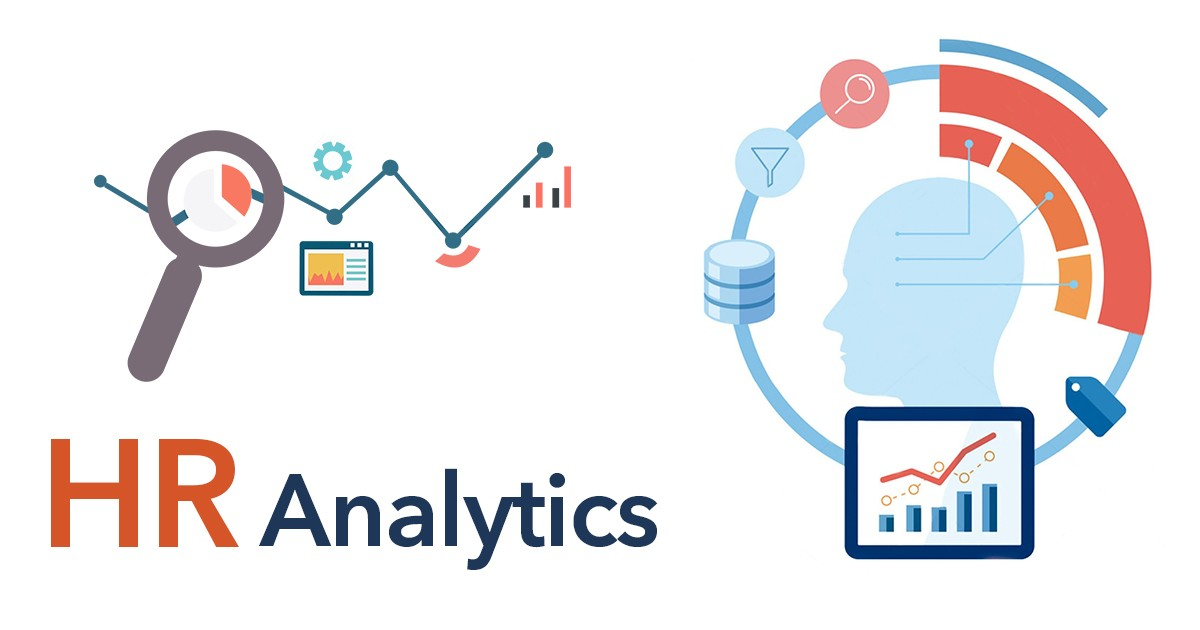

______
## Project Overview

This project aims to analyze employee data to identify patterns and segments within the workforce. By applying dimensionality reduction through Principal Component Analysis (PCA) and clustering techniques, we can uncover meaningful groups of employees that share similar characteristics. These insights can inform HR strategies related to retention, engagement, and talent management.



## Dataset
[Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) on Kaggle, containing data related to employee turnover and features such as satisfaction level, average monthly hours, and more.

### 1. Data Exploration
- Understand the structure of HR analytics data.
- Identify key features related to employee turnover.

__________

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
import missingno as msno
import warnings
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Ignore warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

### 1. Data Exploration and Understanding

First, let's load the dataset and explore its structure to understand the available features and overall data quality.


In [ ]:
# Load the dataset
df = pd.read_csv("Dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Display basic dataset information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Employees: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Preview the first few rows
df.head()

> ## 1.1 Data Overview

Let's check the data types, basic statistics, and overall structure of our dataset.

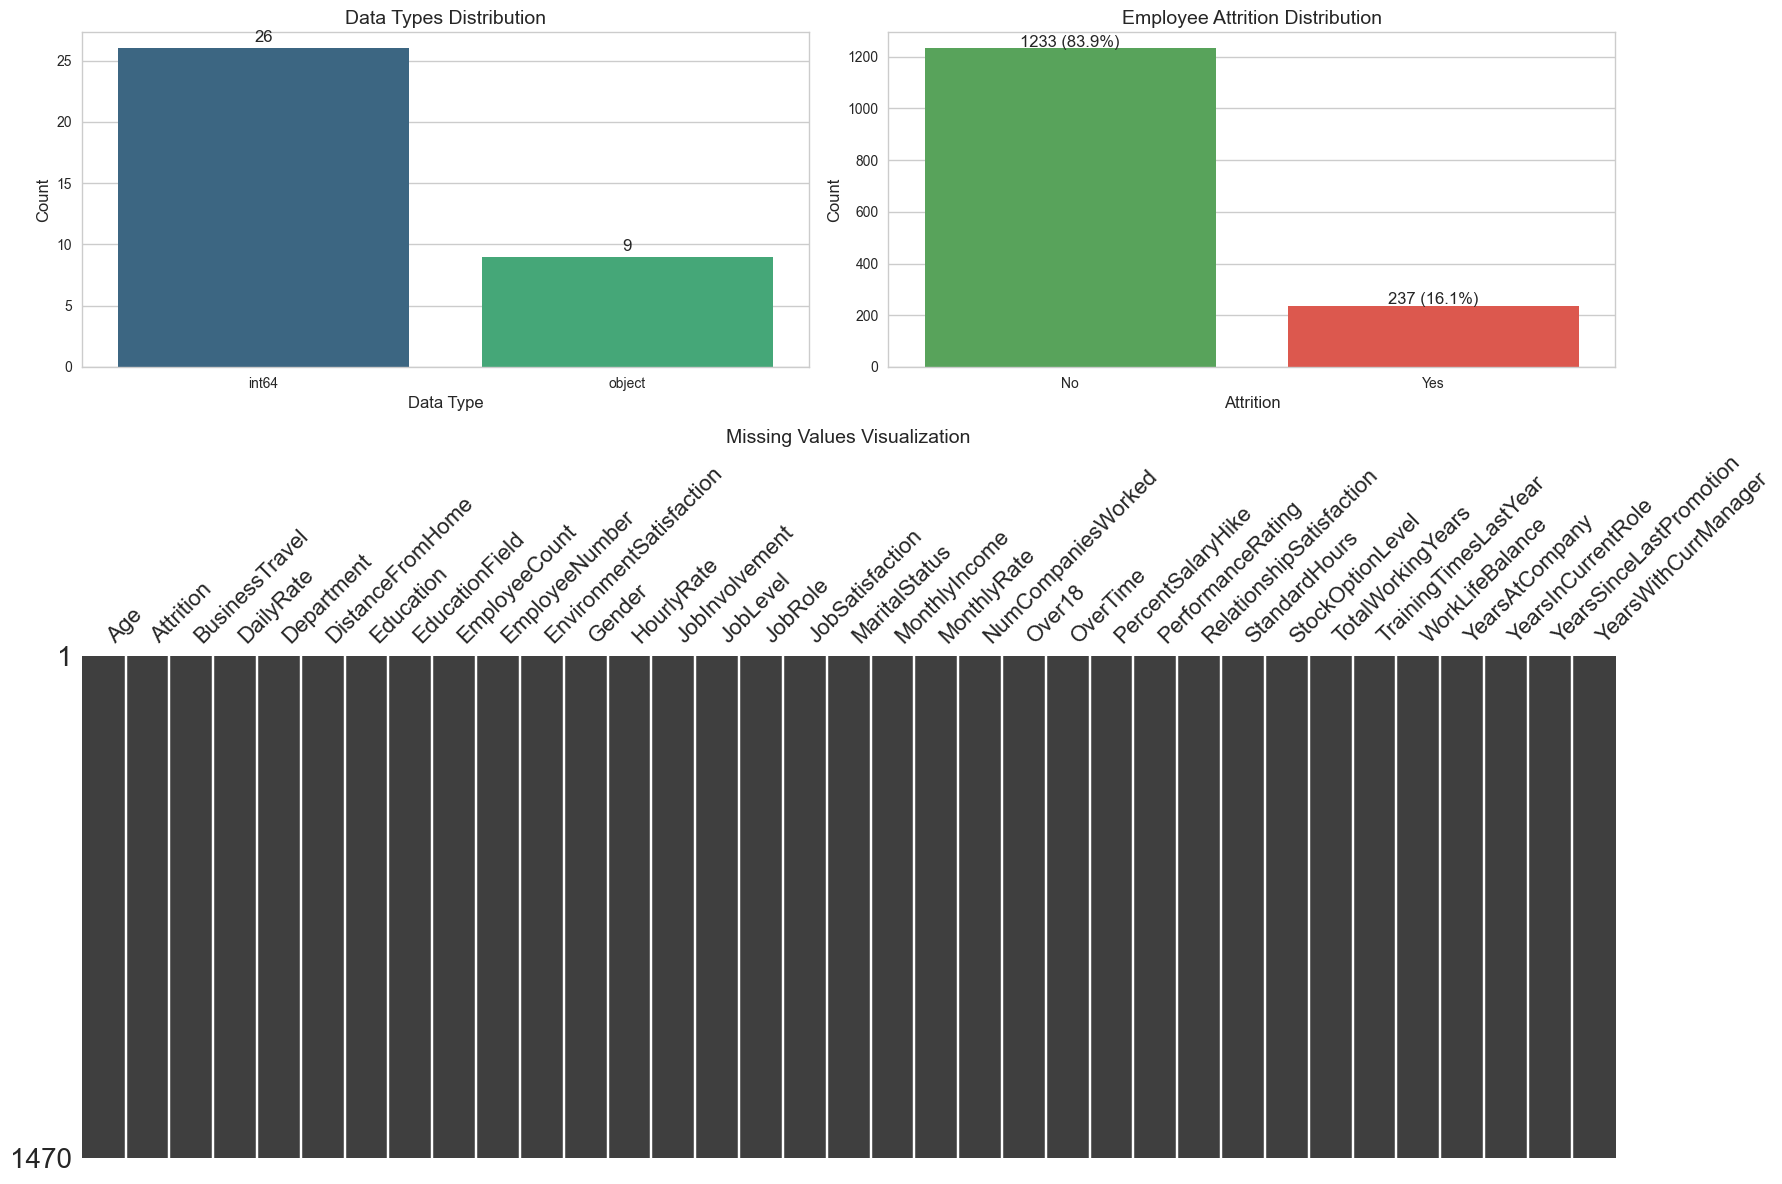


Summary statistics for numerical features:



Dataset Shape: (1470, 35)
Number of Employees: 1470
Number of Features: 35

Number of duplicate rows: 0

Numerical columns (26):
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Categorical columns (9):
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Missing Values Summary:
No missing values found in the dataset


In [236]:
# Create a figure with subplots for better organization
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.5])

# Data types and missing values overview
ax0 = plt.subplot(gs[0, 0])
dtypes_counts = df.dtypes.value_counts()
sns.barplot(x=dtypes_counts.index.astype(str), y=dtypes_counts.values, palette='viridis', ax=ax0)
ax0.set_title('Data Types Distribution', fontsize=14)
ax0.set_ylabel('Count')
ax0.set_xlabel('Data Type')
for i, v in enumerate(dtypes_counts.values):
    ax0.text(i, v + 0.5, str(v), ha='center')

# Attrition distribution
ax1 = plt.subplot(gs[0, 1])
# Calculate attrition counts first
attrition_counts = df['Attrition'].value_counts()
sns.barplot(x=attrition_counts.index, y=attrition_counts.values, palette=['#4CAF50', '#F44336'], ax=ax1)
ax1.set_title('Employee Attrition Distribution', fontsize=14)
ax1.set_xlabel('Attrition')
ax1.set_ylabel('Count')
for i, v in enumerate(attrition_counts.values):
    ax1.text(i, v + 5, f"{v} ({v/df.shape[0]:.1%})", ha='center')

# Missing values visualization
ax2 = plt.subplot(gs[1, :])
msno.matrix(df, ax=ax2)
ax2.set_title('Missing Values Visualization', fontsize=14)

plt.tight_layout()
plt.show()

# Display summary statistics for numerical features
print("\nSummary statistics for numerical features:")
display(df.describe().round(2).T.style.background_gradient(cmap='Blues'))

# Print dataset info
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Employees: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Separate numerical and categorical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])
categorical_df = df.select_dtypes(include=['object'])

# Print feature types
print(f"\nNumerical columns ({len(numerical_df.columns)}):")
print(numerical_df.columns.tolist())

print(f"\nCategorical columns ({len(categorical_df.columns)}):")
print(categorical_df.columns.tolist())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Summary:")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found in the dataset")

## Overview
 **Clean and balanced HR dataset** of 1,470 employees with **35 features** (26 numerical, 9 categorical). No duplicates or missing values were found, ensuring high-quality input for modeling.

## Key Observations
- **Attrition Rate**: 16.1% of employees left the company.
- **Data Quality**: Zero missing values, zero duplicates → ideal for ML modeling.
- **Feature Balance**:
  - Mostly numeric data (26/35).
  - Useful business fields: `JobSatisfaction`, `WorkLifeBalance`, `OverTime`, etc.
- **Invariant Columns**: Features like `EmployeeCount` and `StandardHours` have no variability and may be dropped.

_________

>## 1.2 Exploratory Data Analysis

Let's visualize the distributions of key features and explore relationships between variables to gain insights into our dataset.

- Distribution of key numerical features

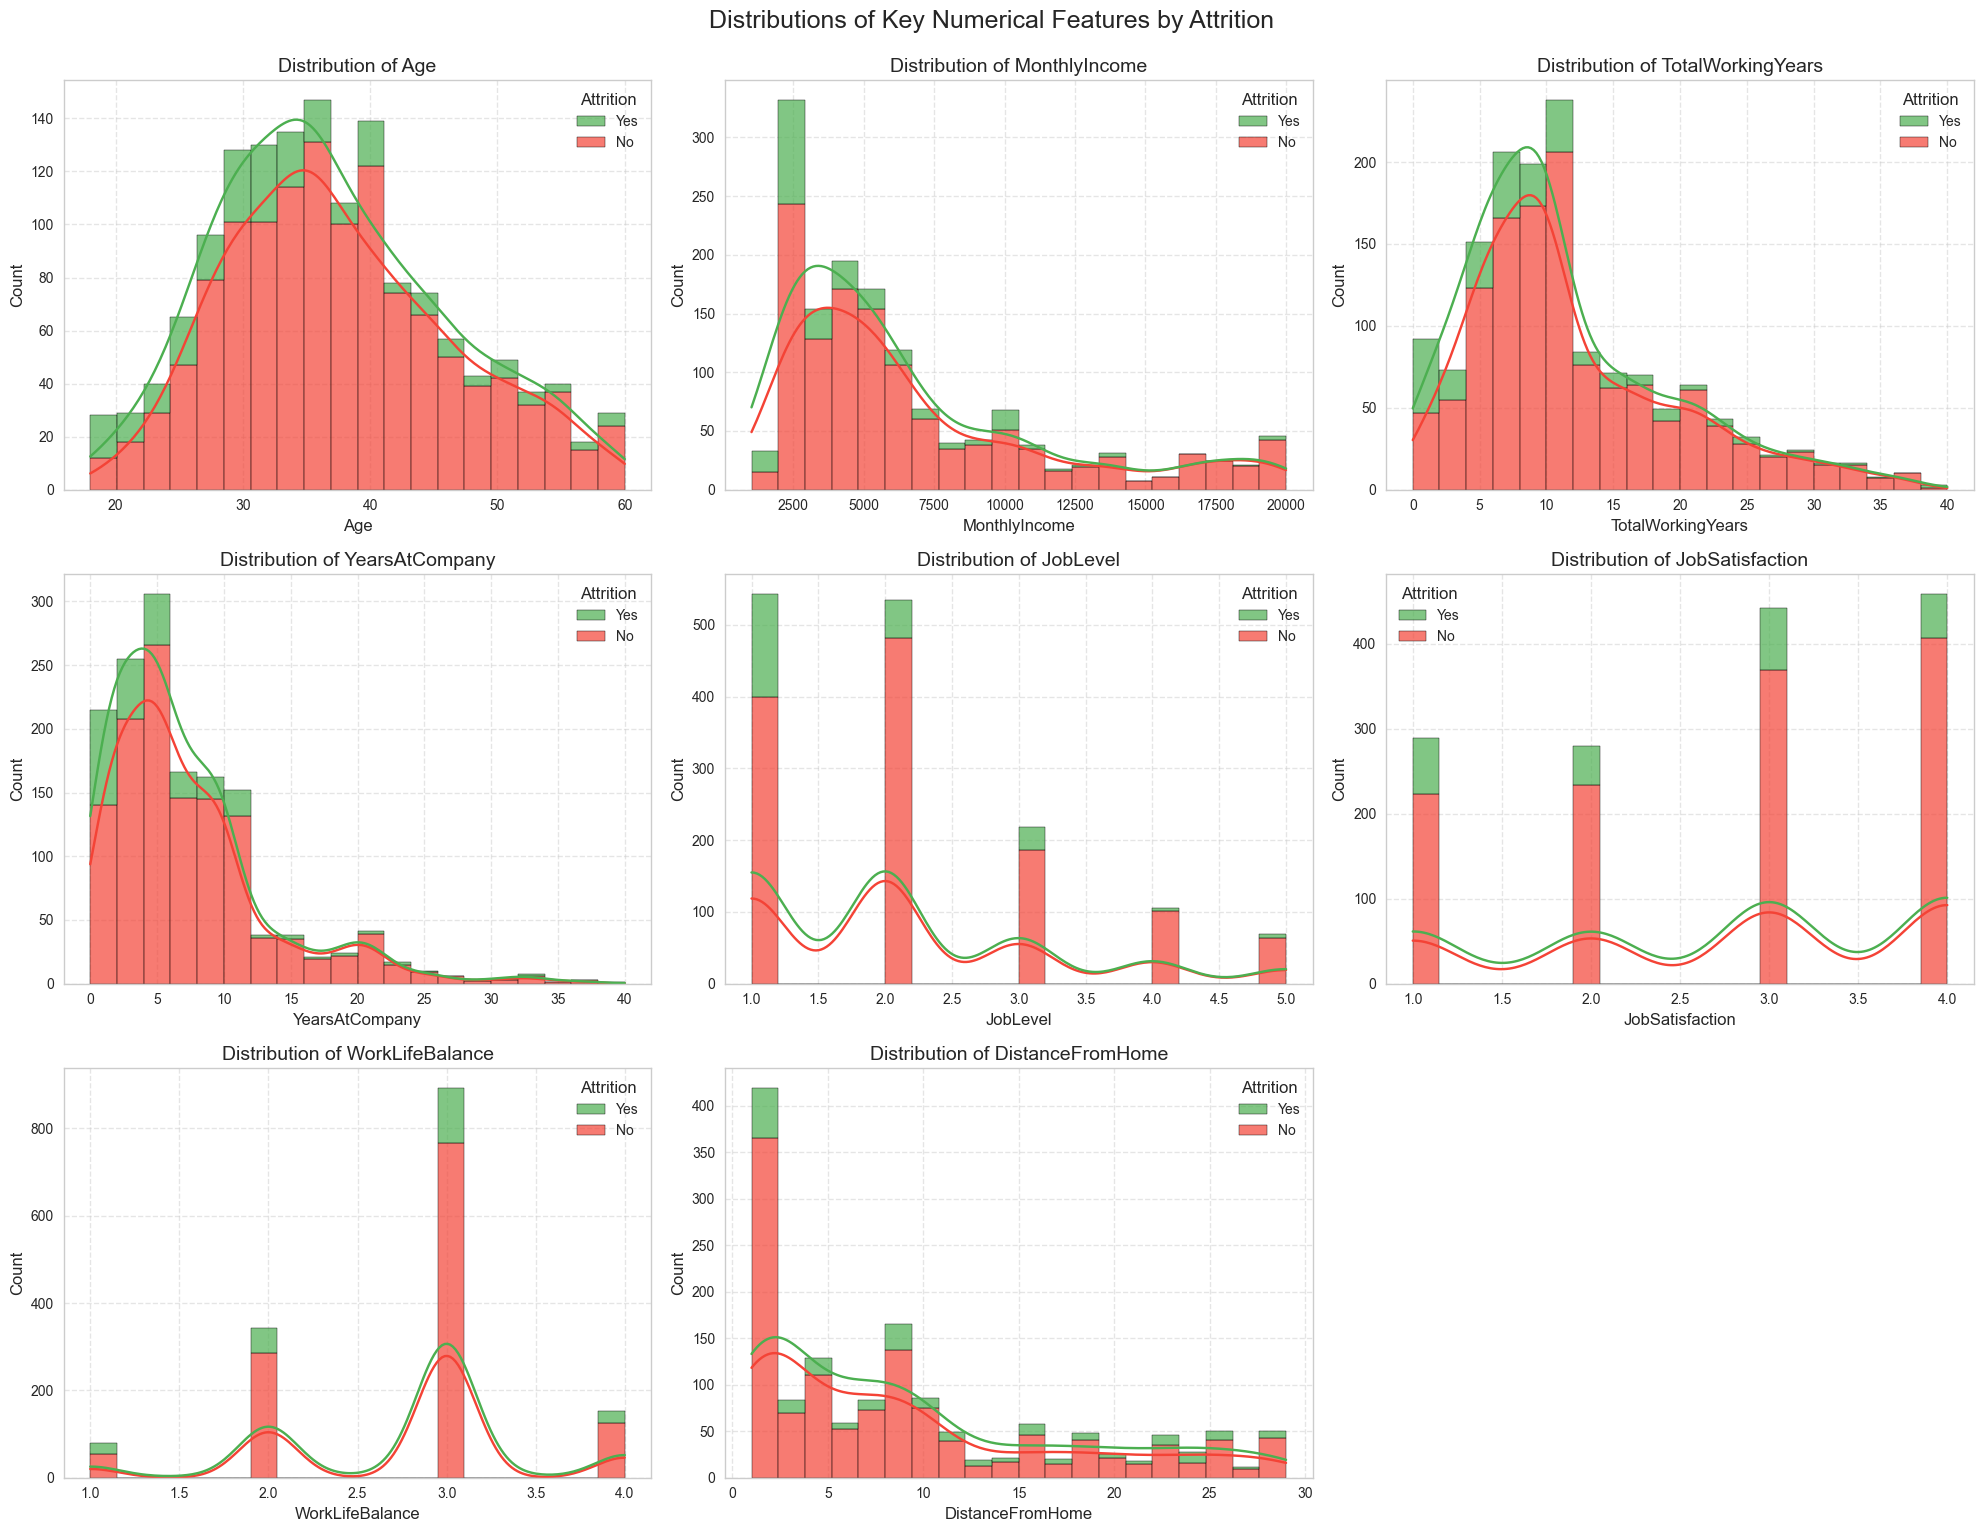

In [237]:
# Distribution of key numerical features
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Select important numerical features for visualization
numerical_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 
                     'JobLevel', 'JobSatisfaction', 'WorkLifeBalance', 'DistanceFromHome']

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=feature, kde=True, hue='Attrition', palette=['#4CAF50', '#F44336'], 
                alpha=0.7, bins=20, multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Distributions of Key Numerical Features by Attrition', fontsize=18, y=1.02)
plt.show()


## Distributions by Attrition – Summary Insights

> This section highlights key numerical feature differences between employees who stayed vs. those who left.

### Key Takeaways:
- **Younger Employees** are more likely to leave (Age skewed left).
- **Lower Monthly Income** is associated with higher attrition.
- **Shorter Tenure** (fewer total working years and years at company) increases attrition risk.
- **Low Job Level** (1 or 2) is more common among those who left.
- **Job Satisfaction**: Leavers report lower satisfaction (levels 1–2).
- **Work-Life Balance**: Poor ratings show slightly more attrition.
- **Distance from Home**: Longer commutes show a mild link to attrition.

> These findings suggest early-career, lower-paid, and less-satisfied employees are at higher risk of leaving.



______

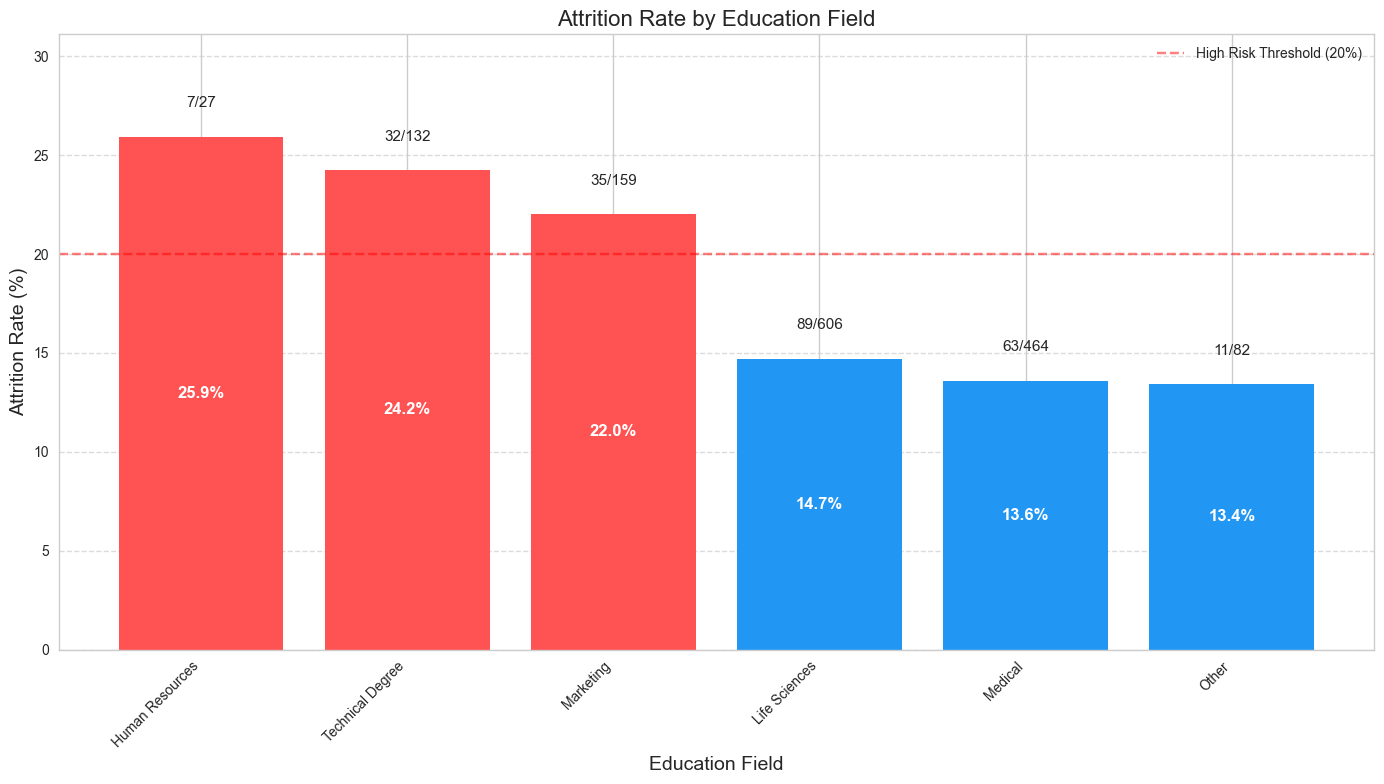

In [238]:
# Create a simple bar chart showing attrition rates by education field
plt.figure(figsize=(14, 8))

# Calculate percentages of attrition for each education field
attrition_percentages = df.groupby('EducationField')['Attrition'].apply(
    lambda x: 100 * sum(x == 'Yes') / len(x)
).sort_values(ascending=False)

# Plot bar chart
bars = plt.bar(attrition_percentages.index, attrition_percentages.values,
        color=['#FF5252' if x > 20 else '#2196F3' for x in attrition_percentages])

# Add count labels at the top of each bar
for i, (field, percentage) in enumerate(attrition_percentages.items()):
    yes_count = sum(df[df['EducationField'] == field]['Attrition'] == 'Yes')
    total_count = len(df[df['EducationField'] == field])
    plt.text(i, percentage + 1.5, f"{yes_count}/{total_count}",
             ha='center', fontsize=11)

# Add percentage labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{height:.1f}%', ha='center', va='center', 
             color='white', fontweight='bold', fontsize=12)

# Customize the plot
plt.title('Attrition Rate by Education Field', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=14)
plt.xlabel('Education Field', fontsize=14)
plt.ylim(0, max(attrition_percentages) * 1.2)  # Add some space for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Add a horizontal line at 20% to indicate high risk threshold
plt.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='High Risk Threshold (20%)')
plt.legend()

plt.tight_layout()
plt.show()


### Education Field and Attrition Risk

> This chart highlights education fields with higher attrition risk, based on a 20% threshold.

#### Key Insights:
- High-risk fields (above 20% attrition):
  - Human Resources – 25.9%
  - Technical Degree – 24.2%
  - Marketing – 22.0%

- Lower-risk fields (below 20%):
  - Life Sciences – 14.7%
  - Medical – 13.6%
  - Other – 13.4%

> These insights suggest that targeted retention strategies are especially needed in HR, technical, and marketing areas.
____

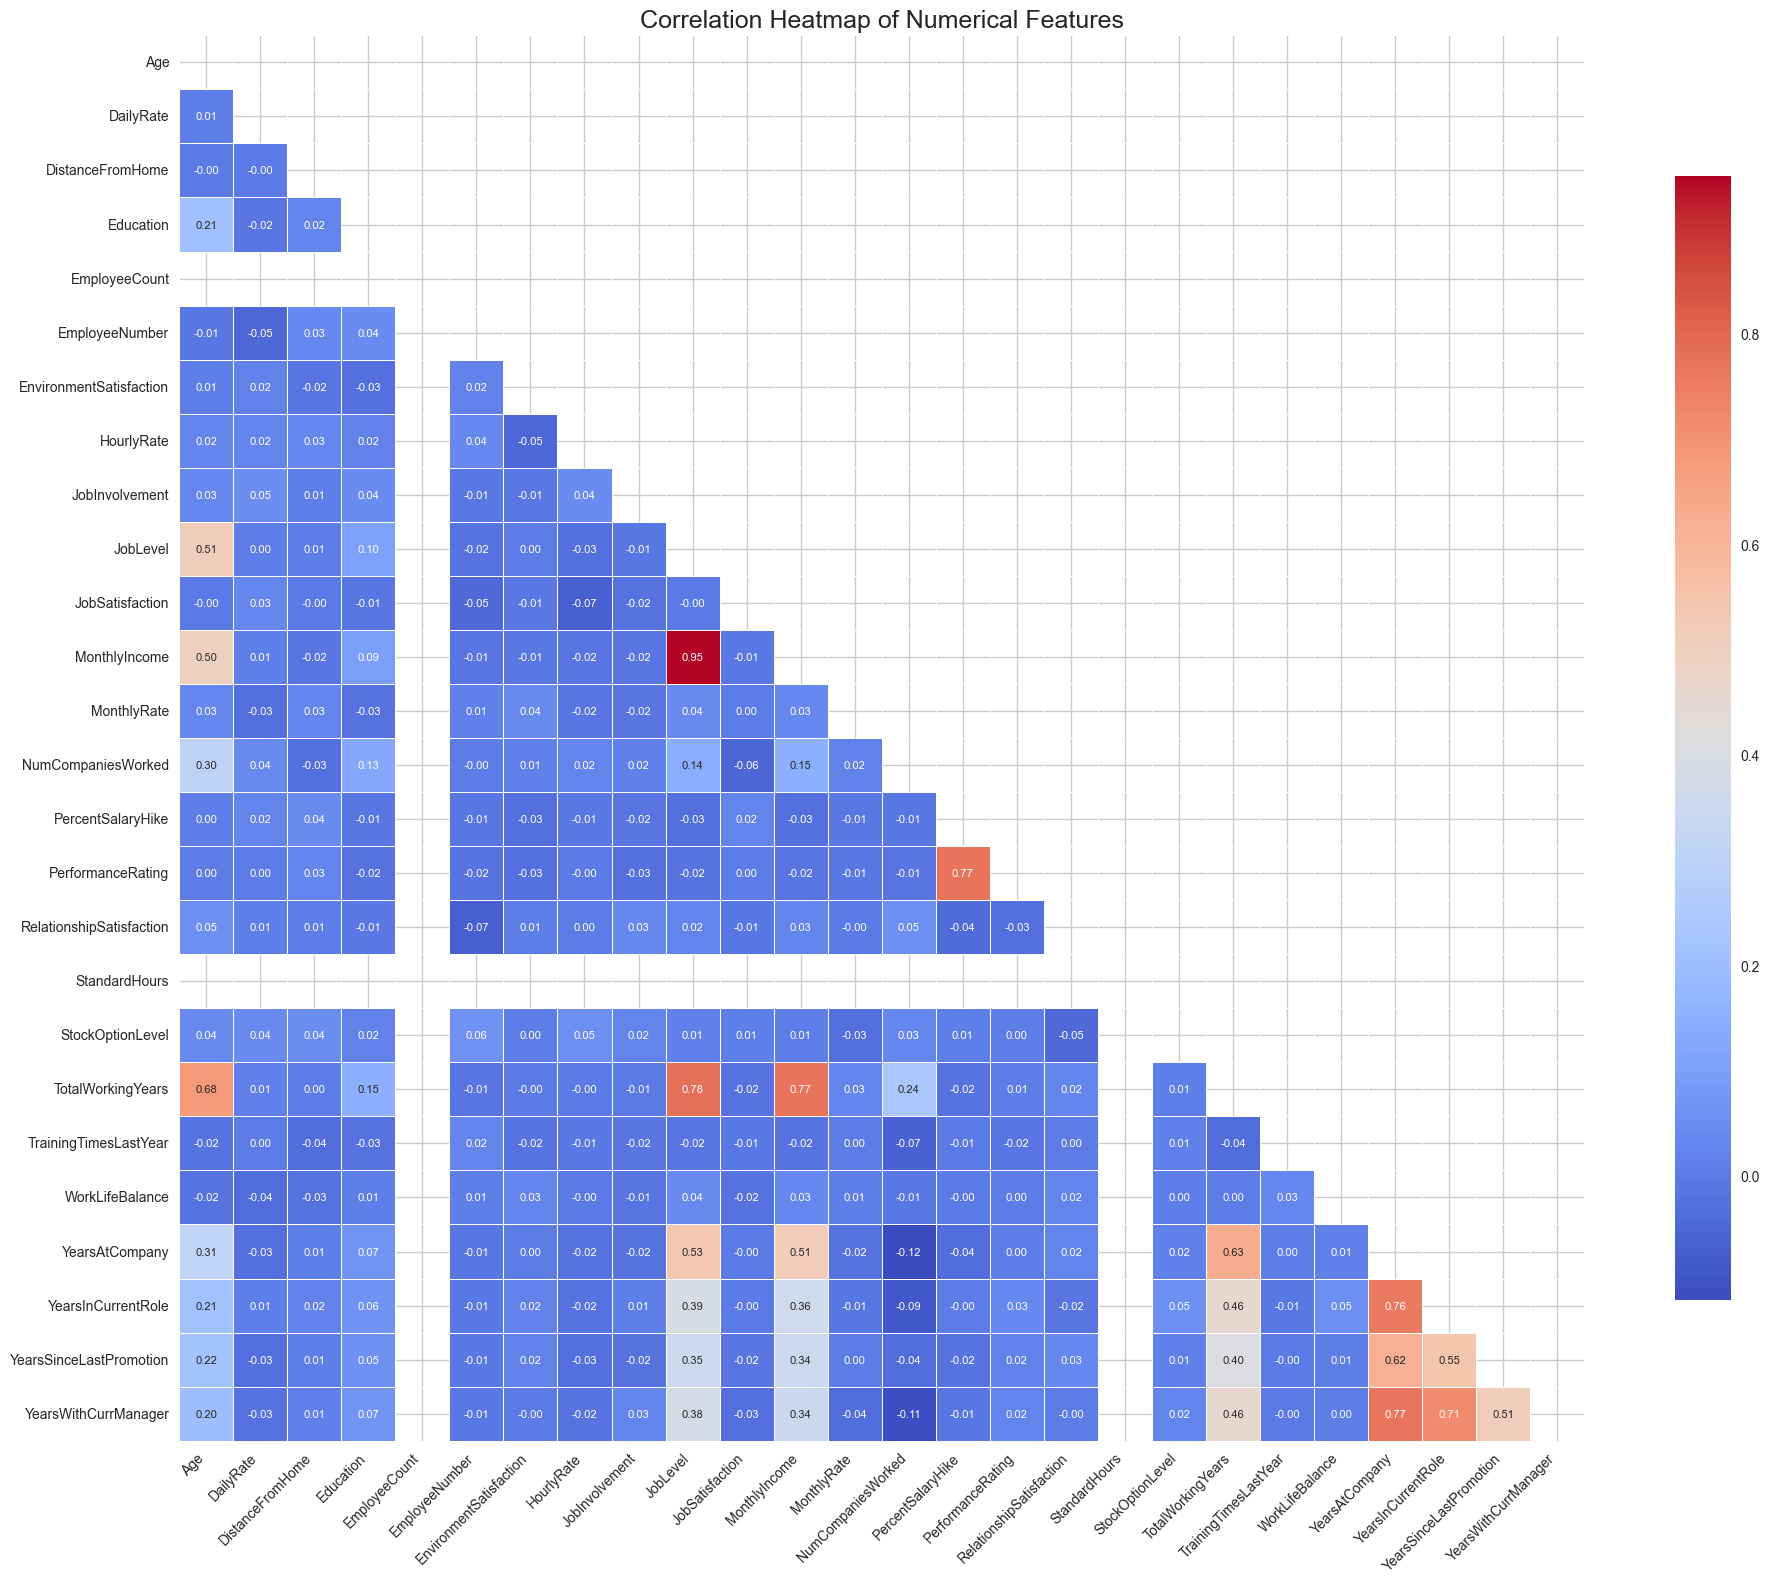

In [239]:


# Correlation heatmap for numerical features
plt.figure(figsize=(20, 16))
correlation = numerical_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, linewidths=0.5, 
            cbar_kws={"shrink": .8}, square=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Correlation Heatmap of Numerical Features

> The heatmap shows how numerical features correlate with each other.

#### Key Observations:
- Strongest correlation:  
  - `TotalWorkingYears` and `YearsAtCompany`: **0.77**  
  - `JobLevel` and `MonthlyIncome`: **0.78**  
  - `YearsWithCurrManager` and `YearsInCurrentRole`: **0.77**

> Most other features show low correlations (|r| < 0.4), indicating low multicollinearity risk. Feature selection or dimensionality reduction may still be considered, especially among highly related job tenure indicators.


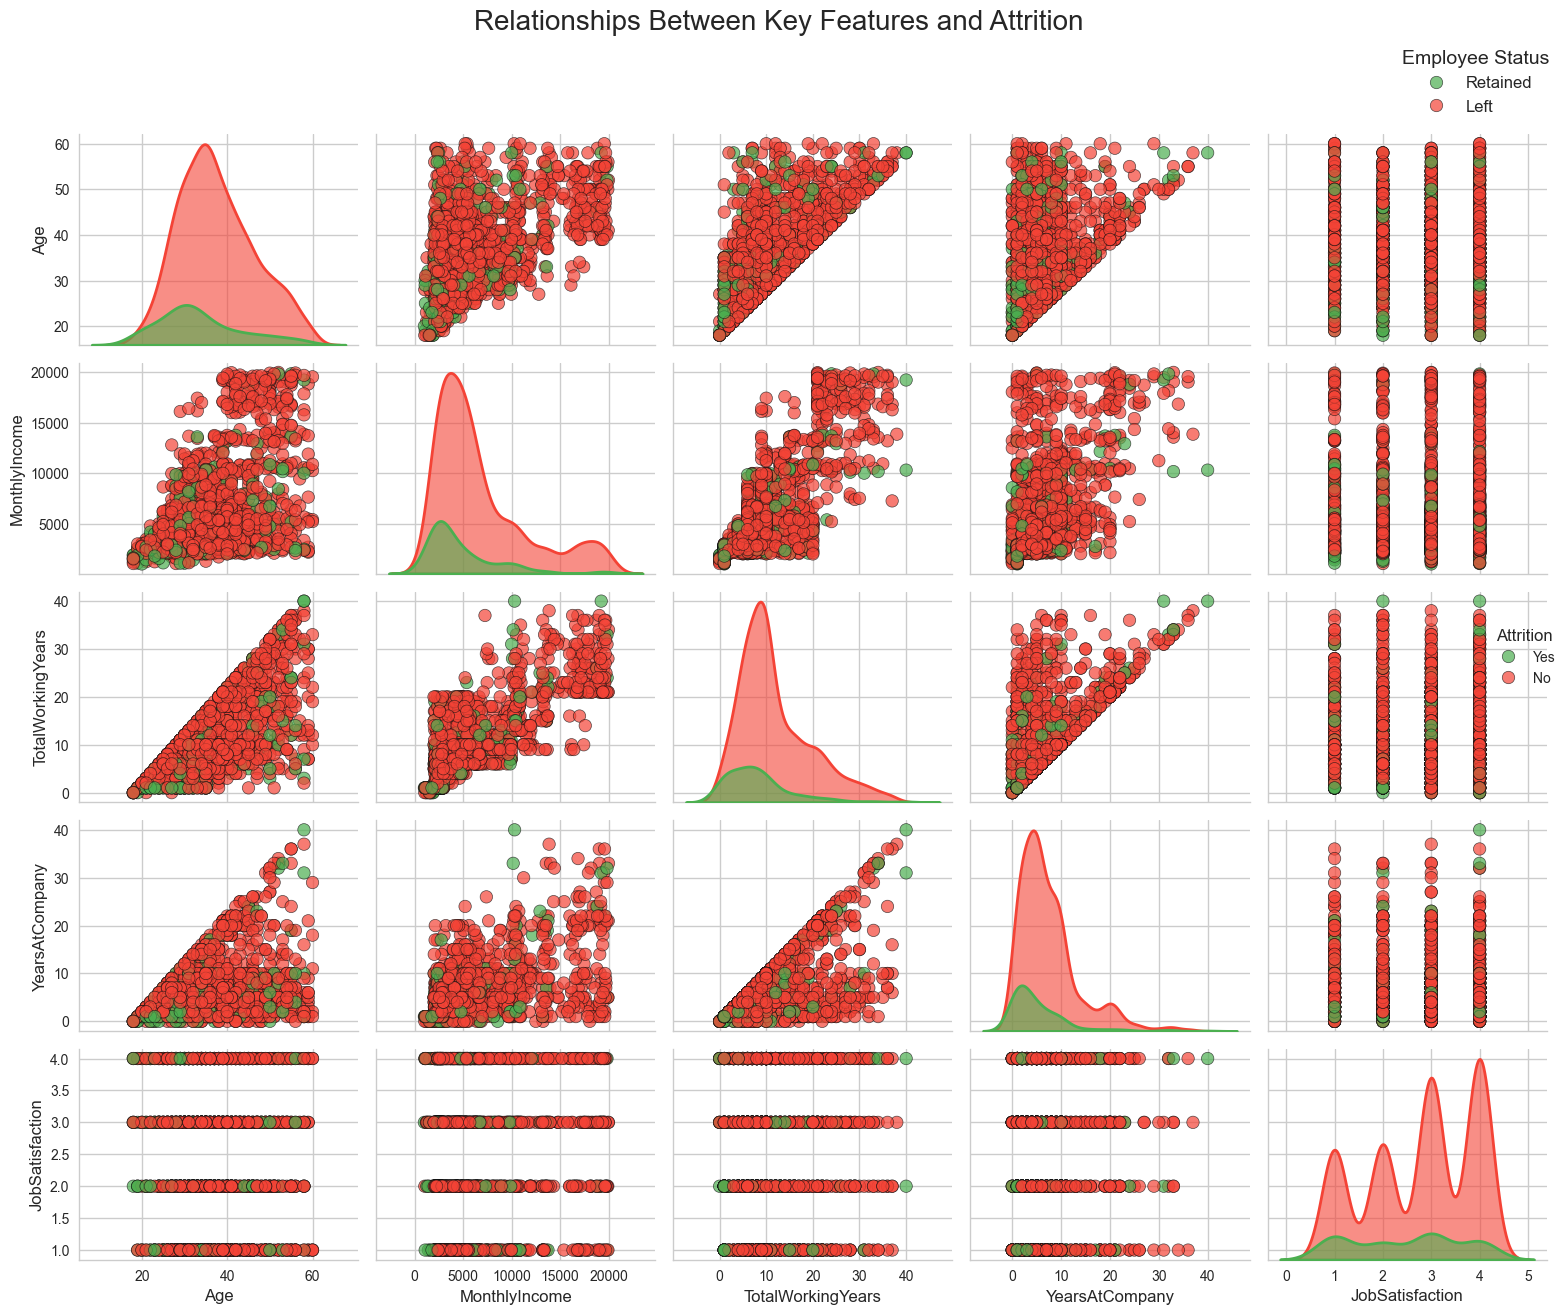

In [240]:
# Create a pairplot of key features with improved visualization
key_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'JobSatisfaction']

# Create the pairplot with enhanced styling
g = sns.pairplot(df[key_features + ['Attrition']], 
                hue='Attrition', 
                palette=['#4CAF50', '#F44336'],
                diag_kind='kde', 
                height=2.5,
                aspect=1.2,
                plot_kws={'alpha': 0.7, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5}, 
                diag_kws={'alpha': 0.6, 'linewidth': 2, 'shade': True})

# Improve the appearance
g.fig.suptitle('Relationships Between Key Features and Attrition', fontsize=20, y=1.05)
g.fig.subplots_adjust(top=0.95)

# Add descriptive legend
handles = g._legend_data.values()
labels = ['Retained', 'Left']
g.fig.legend(handles, labels, title='Employee Status', 
             loc='upper right', bbox_to_anchor=(1, 1.03), 
             fontsize=12, title_fontsize=14)

# Enhance axis labels
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

### Relationships Between Key Features and Attrition

> Pairplot reveals important contrasts between employees who stayed vs. those who left.

#### Insights:
- **Age**: Most attrition occurs between **25–35 years old**.
- **Monthly Income**: Leavers tend to earn **less than retained employees**.
- **TotalWorkingYears**: Attrition is higher among those with **low experience**.
- **YearsAtCompany**: Higher turnover among **recent hires** (0–3 years).
- **JobSatisfaction**: Lower satisfaction is more frequent among those who left.

> These trends highlight at-risk profiles: younger, less experienced, and less satisfied employees.
_______

## 1.3 Advanced Feature Analysis

> Let's analyze specific relationships and create more informative visualizations for deeper insights.

>### - Income vs Years at Company by Job Role

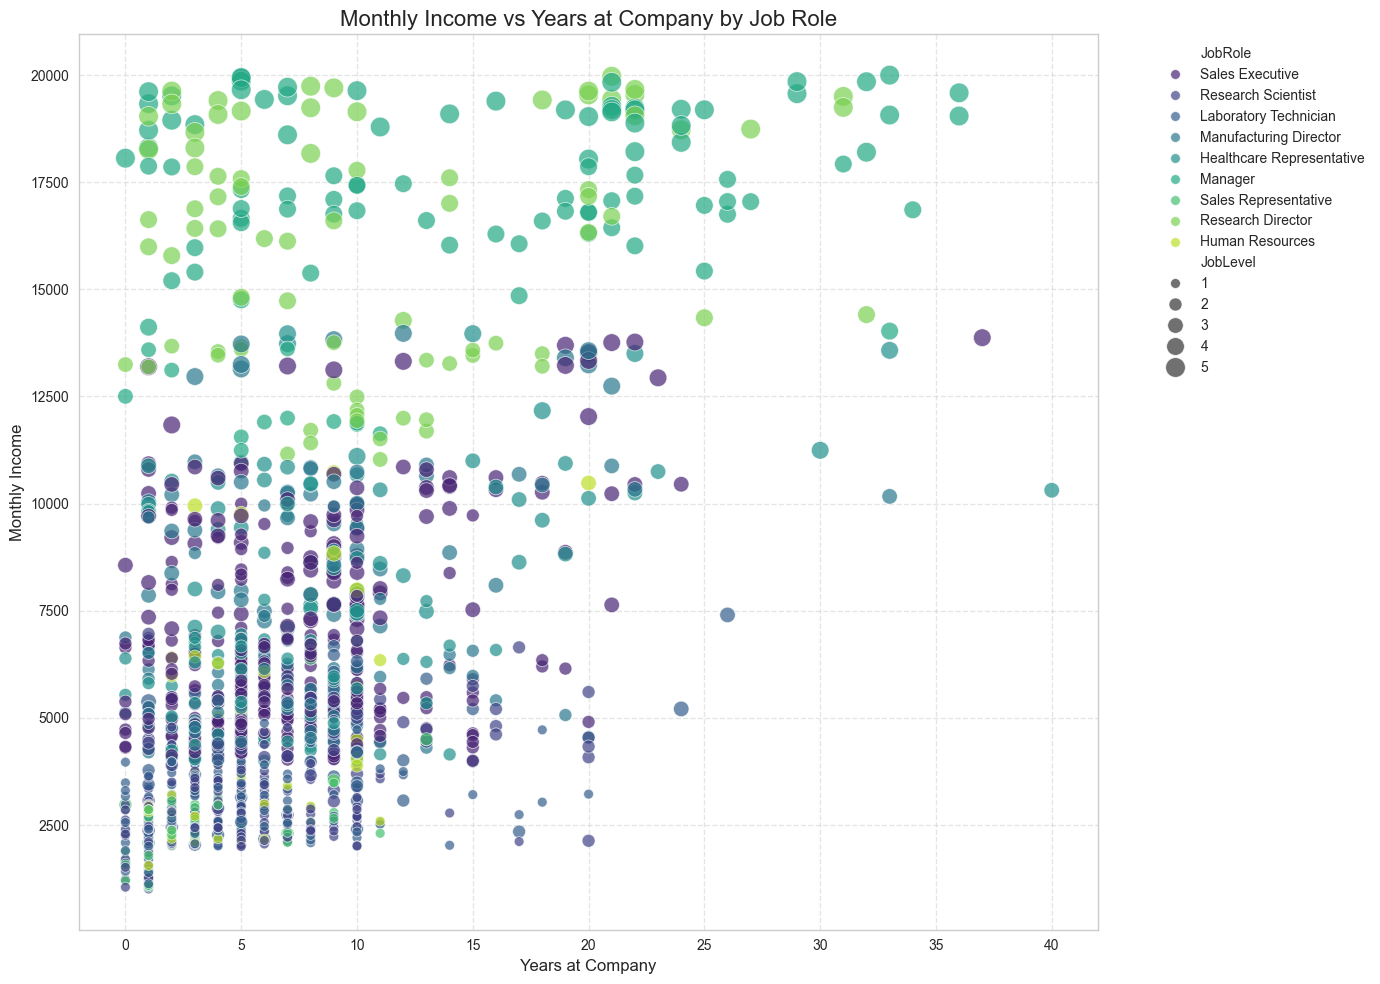

In [241]:
# Income vs Years at Company by Job Role
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df, x='YearsAtCompany', y='MonthlyIncome', hue='JobRole', size='JobLevel',
               sizes=(50, 200), alpha=0.7, palette='viridis')
plt.title('Monthly Income vs Years at Company by Job Role', fontsize=16)
plt.xlabel('Years at Company')
plt.ylabel('Monthly Income')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Income vs Tenure by Job Role

> The scatterplot shows how **Monthly Income** evolves with **Years at Company**, segmented by **Job Role** and **Job Level**.

#### Observations:
- Income increases with **tenure**, especially at **higher job levels** (larger dots).
- High-paying roles like **Manager** and **Research Director** dominate upper income brackets.
- Roles such as **Sales Executive** and **Laboratory Technician** show limited income growth despite longer tenure.
- Most low-income employees are in **Job Level 1–2**, regardless of years spent.

> Business Implication:
- Develop **career path incentives** for entry-level roles to retain employees.
- Consider **performance-based raises** earlier in tenure to reduce attrition.
____

>### - Age vs Income by Department with improved visualization

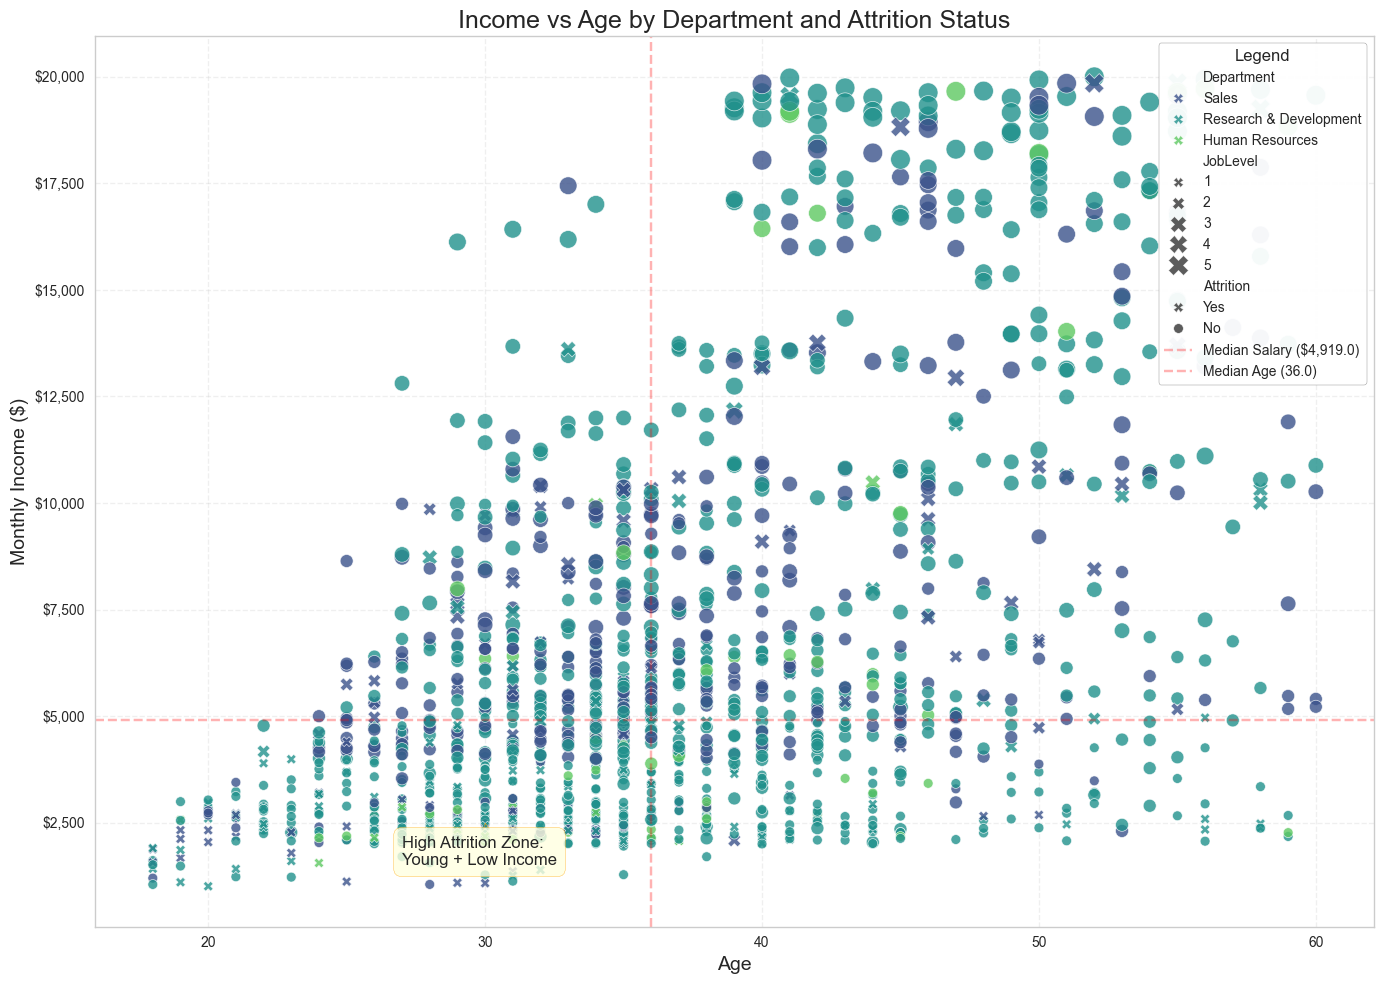

In [242]:
from matplotlib.ticker import FuncFormatter

# Age vs Income by Department with improved visualization
plt.figure(figsize=(14, 10))

# Create a more visually appealing scatterplot with enhanced styling
scatter = sns.scatterplot(
    data=df, 
    x='Age', 
    y='MonthlyIncome', 
    hue='Department', 
    style='Attrition',
    size='JobLevel', 
    sizes=(50, 200), 
    alpha=0.8,
    palette='viridis',
    markers={'Yes': 'X', 'No': 'o'},
    edgecolor='w',
    linewidth=0.5
)

# Add reference lines for median values
plt.axhline(y=df['MonthlyIncome'].median(), color='red', linestyle='--', alpha=0.3, label=f'Median Salary (${df["MonthlyIncome"].median():,})')
plt.axvline(x=df['Age'].median(), color='red', linestyle='--', alpha=0.3, label=f'Median Age ({df["Age"].median()})')

# Improve plot appearance
plt.title('Income vs Age by Department and Attrition Status', fontsize=18)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Monthly Income ($)', fontsize=14)
plt.grid(linestyle='--', alpha=0.3)

# Format y-axis labels as currency
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add annotations for high-attrition regions
plt.annotate('High Attrition Zone:\nYoung + Low Income', 
             xy=(30, 2500), 
             xytext=(27, 1500),
             bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='orange'))

# Customize legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, 
           title='Legend', 
           loc='upper right',
           frameon=True,
           framealpha=0.95,
           edgecolor='gray')

plt.tight_layout()
plt.show()

### Income vs Age: Attrition Risk Zone

> This plot highlights how **employee age** and **monthly income** relate to **attrition**, across departments and job levels.

#### Insights:
- A clear **"High Attrition Zone"** appears: employees **younger than 36** and earning **less than $4,919** are more likely to leave.
- Most attrition cases fall in **Sales** and **Research & Development**, especially at **lower job levels** (1–2).
- As **age and income increase**, attrition drops significantly.

#### Business Takeaways:
- Focus **retention strategies** on younger, low-paid employees.
- Offer **early career growth plans**, better **entry-level compensation**, and **mentorship programs** to reduce early exits.
___

>### - Work-Life Balance vs Job Satisfaction

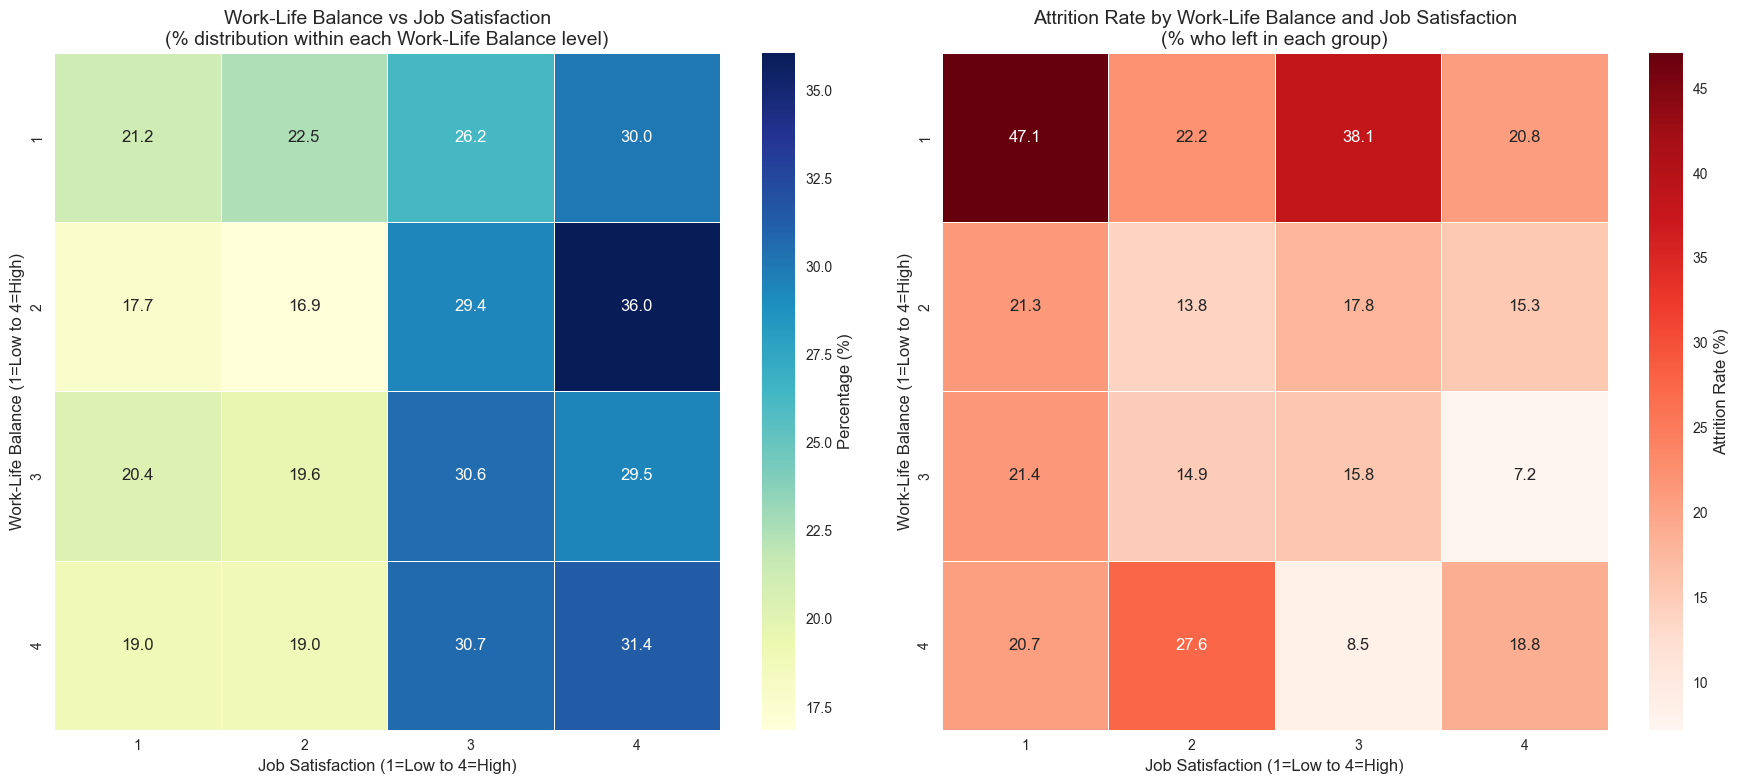


Summary of Work-Life Balance and Job Satisfaction:
Average Work-Life Balance: 2.76/4
Average Job Satisfaction: 2.73/4

Attrition by Work-Life Balance levels:


WorkLifeBalance
1    31.250000
4    17.647059
2    16.860465
3    14.221725
Name: Attrition, dtype: float64

In [243]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Work-Life Balance vs Job Satisfaction heatmap
balance_satisfaction = pd.crosstab(df['WorkLifeBalance'], df['JobSatisfaction'], 
                                  values=df['EmployeeCount'], aggfunc='sum', normalize='index')
balance_satisfaction = balance_satisfaction * 100  # Convert to percentage

# Create heatmap with enhanced styling
sns.heatmap(balance_satisfaction, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=0.5, 
           cbar_kws={"label": "Percentage (%)"}, ax=ax1)
ax1.set_title('Work-Life Balance vs Job Satisfaction\n(% distribution within each Work-Life Balance level)', fontsize=14)
ax1.set_xlabel('Job Satisfaction (1=Low to 4=High)')
ax1.set_ylabel('Work-Life Balance (1=Low to 4=High)')

# Second subplot: Add attrition analysis by Work-Life Balance and Job Satisfaction
# Create cross-tabulation with attrition rates
attrition_data = df.pivot_table(index='WorkLifeBalance', columns='JobSatisfaction', 
                               values='Attrition', aggfunc=lambda x: 100 * (x == 'Yes').mean())

# Create heatmap showing attrition percentages
sns.heatmap(attrition_data, annot=True, cmap='Reds', fmt='.1f', linewidths=0.5, 
           cbar_kws={"label": "Attrition Rate (%)"}, ax=ax2)
ax2.set_title('Attrition Rate by Work-Life Balance and Job Satisfaction\n(% who left in each group)', fontsize=14)
ax2.set_xlabel('Job Satisfaction (1=Low to 4=High)')
ax2.set_ylabel('Work-Life Balance (1=Low to 4=High)')

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary of Work-Life Balance and Job Satisfaction:")
print(f"Average Work-Life Balance: {df['WorkLifeBalance'].mean():.2f}/4")
print(f"Average Job Satisfaction: {df['JobSatisfaction'].mean():.2f}/4")
print("\nAttrition by Work-Life Balance levels:")
display(df.groupby('WorkLifeBalance')['Attrition'].apply(lambda x: 100 * (x == 'Yes').mean()).sort_values(ascending=False))

### Work-Life Balance & Job Satisfaction Impact on Attrition

> These heatmaps explore how combinations of job satisfaction and work-life balance affect attrition behavior.

#### Key Observations:
- The **highest attrition (47.1%)** occurs when both **Work-Life Balance** and **Job Satisfaction** are at their **lowest levels (1)**.
- Attrition **decreases consistently** with improvements in either dimension.
- The **lowest attrition (7.2%)** is seen in employees with **moderate balance (3)** and **high satisfaction (4)**.

#### Business Implications:
- Employees with **poor work-life balance and low job satisfaction are at extreme risk of leaving**.
- Prioritize:
  - **Flexible work policies**.
  - **Satisfaction-focused engagement programs**.
  - **Monitoring low-satisfaction & low-balance segments** to prevent early exits.
____

>#### - Attrition by Age Group and Gender

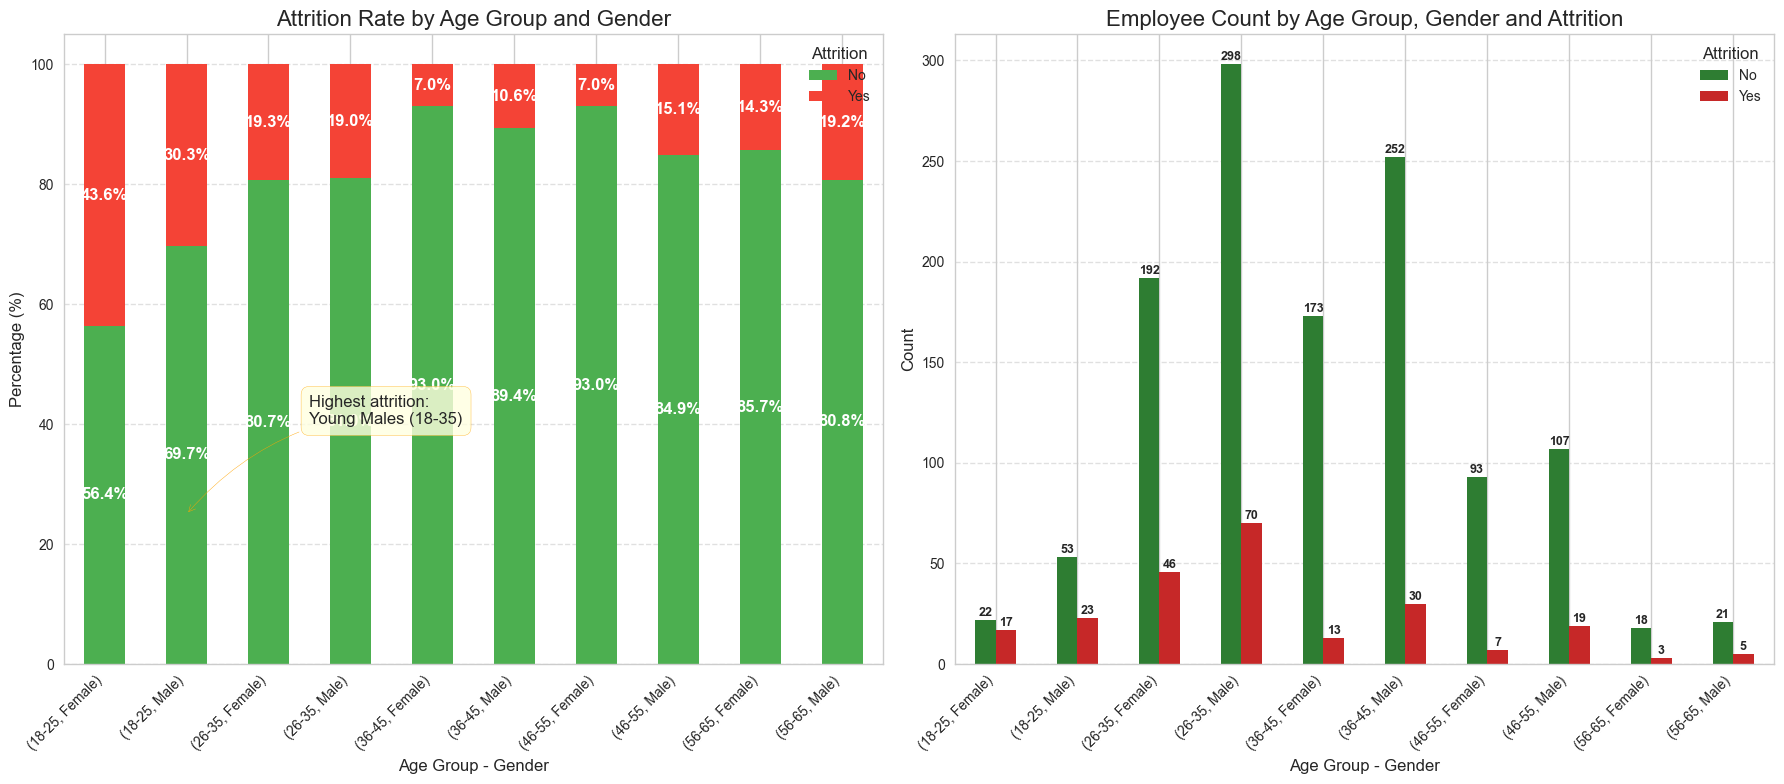


Summary of Attrition by Age Group and Gender:


Attrition               No        Yes
AgeGroup Gender                      
18-25    Female  56.410256  43.589744
         Male    69.736842  30.263158
26-35    Female  80.672269  19.327731
56-65    Male    80.769231  19.230769
26-35    Male    80.978261  19.021739
46-55    Male    84.920635  15.079365

In [244]:
# Attrition by Age Group and Gender
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65], 
                       labels=['18-25', '26-35', '36-45', '46-55', '56-65'])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Bar chart with percentages
age_gender_attrition = pd.crosstab([df['AgeGroup'], df['Gender']], df['Attrition'], 
                                   normalize='index') * 100

# Plot stacked bar chart
age_gender_attrition.plot(kind='bar', stacked=True, 
                         color=['#4CAF50', '#F44336'],
                         ax=ax1)

# Add percentage labels on bars
for i, p in enumerate(ax1.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_x(), p.get_y()
    
    if height > 5:  # Only show label if segment is large enough
        ax1.text(x + width/2, y + height/2, f'{height:.1f}%', 
                ha='center', va='center', color='white', fontweight='bold')

# Enhance first subplot
ax1.set_title('Attrition Rate by Age Group and Gender', fontsize=16)
ax1.set_xlabel('Age Group - Gender', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.legend(title='Attrition', loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Second subplot: Count visualization with clearer colors
counts = pd.crosstab([df['AgeGroup'], df['Gender']], df['Attrition'])
counts.plot(kind='bar', ax=ax2, color=['#2E7D32', '#C62828'])

# Add count labels above bars
for i, p in enumerate(ax2.patches):
    height = p.get_height()
    ax2.annotate(f'{height}', 
                xy=(p.get_x() + p.get_width()/2, height + 0.5),
                ha='center', va='bottom', fontsize=9,
                fontweight='bold')

# Enhance second subplot
ax2.set_title('Employee Count by Age Group, Gender and Attrition', fontsize=16)
ax2.set_xlabel('Age Group - Gender', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='Attrition')
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Add an annotation highlighting key insight
ax1.annotate('Highest attrition:\nYoung Males (18-35)',
            xy=(1, 25), xytext=(2.5, 40),
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='orange'))

plt.tight_layout()
plt.show()

# Print summary of attrition by age group and gender
print("\nSummary of Attrition by Age Group and Gender:")
display(age_gender_attrition.sort_values(by='Yes', ascending=False).head(6))

### Attrition by Age and Gender

> These charts show how attrition rates vary across different age groups and between genders.

#### Insights:
- **Highest attrition** is found among **young males aged 18–25** (30.3%).
- Female employees in the same age group also show **relatively high attrition** (43.6%), though sample size is smaller.
- Attrition **decreases with age**, stabilizing for employees over 35.

#### Business Implications:
- **Younger employees**—especially men—are more likely to leave.
- Consider:
  - Onboarding support & mentoring for early-career employees.
  - Growth opportunities and tailored retention programs for younger staff.
___

>### Feature importance for predicting Attrition

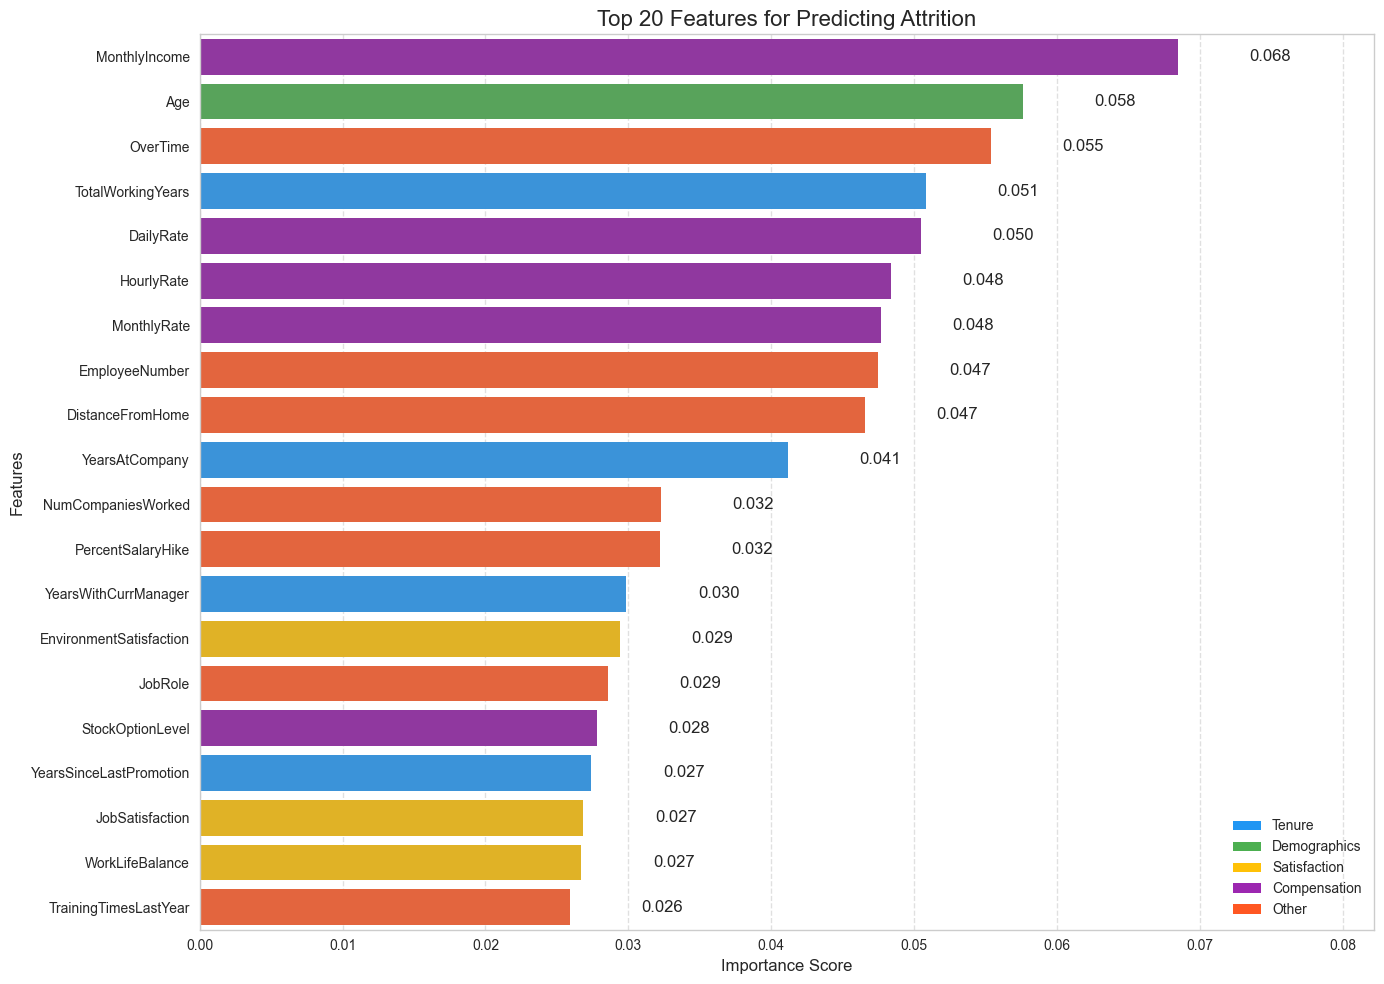


Top 5 most important features for predicting attrition:
MonthlyIncome: 0.0685
Age: 0.0576
OverTime: 0.0554
TotalWorkingYears: 0.0508
DailyRate: 0.0505


In [245]:
from matplotlib.patches import Patch

# Feature importance for predicting Attrition
# First, let's drop the AgeGroup column to avoid conflict since it's derived from Age
if 'AgeGroup' in df.columns:
    X_encoded = df.drop('AgeGroup', axis=1).copy()
else:
    X_encoded = df.copy()

# Encode categorical variables for importance analysis
le = LabelEncoder()
for col in X_encoded.select_dtypes(include=['object']).columns:
    if col != 'Attrition':  # Don't encode the target yet
        X_encoded[col] = le.fit_transform(X_encoded[col])

# Split features and target
X = X_encoded.drop('Attrition', axis=1)
y = (X_encoded['Attrition'] == 'Yes').astype(int)  # Convert to binary (0/1)

# Calculate feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices][:20]  # Top 20 features
feature_importances = importances[indices][:20]

# Create a more visually appealing plot with feature groups
plt.figure(figsize=(14, 10))

# Assign categories to features for coloring
feature_categories = {}
for feature in feature_names:
    if 'Years' in feature:
        feature_categories[feature] = 'Tenure'
    elif feature in ['Age', 'MaritalStatus', 'Gender']:
        feature_categories[feature] = 'Demographics'
    elif feature in ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'RelationshipSatisfaction']:
        feature_categories[feature] = 'Satisfaction'
    elif feature in ['MonthlyIncome', 'DailyRate', 'HourlyRate', 'MonthlyRate', 'StockOptionLevel']:
        feature_categories[feature] = 'Compensation'
    else:
        feature_categories[feature] = 'Other'

# Create a color palette
category_colors = {
    'Tenure': '#2196F3',  # Blue
    'Demographics': '#4CAF50',  # Green
    'Satisfaction': '#FFC107',  # Yellow/Gold
    'Compensation': '#9C27B0',  # Purple
    'Other': '#FF5722'  # Orange
}

# Create the bar chart with category colors
colors = [category_colors[feature_categories[feature]] for feature in feature_names]

# Plot the bar chart
ax = sns.barplot(x=feature_importances, y=feature_names, palette=colors)

# Add importance percentage labels on bars
for i, v in enumerate(feature_importances):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center')

# Add a legend
legend_elements = [Patch(facecolor=color, label=category) 
                  for category, color in category_colors.items()]
plt.legend(handles=legend_elements, loc='lower right')

# Improve the plot appearance
plt.title('Top 20 Features for Predicting Attrition', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, max(feature_importances) * 1.2)  # Add some space for labels
plt.tight_layout()
plt.show()

# Print top 5 features with their importance scores
print("\nTop 5 most important features for predicting attrition:")
for i in range(5):
    print(f"{feature_names[i]}: {feature_importances[i]:.4f}")

### Feature Importance for Attrition Prediction

> This chart highlights the top 20 features most influential in predicting employee attrition.

#### Key Drivers Identified:
- **Compensation factors** dominate:
  - `MonthlyIncome`, `HourlyRate`, `DailyRate` are top contributors.
- **Demographics** like `Age` and `DistanceFromHome` also play a strong role.
- **Work conditions** such as `OverTime`, `EnvironmentSatisfaction`, and `JobSatisfaction` matter significantly.
- **Tenure metrics** like `TotalWorkingYears`, `YearsAtCompany`, `YearsWithCurrManager` reflect employee lifecycle influence.

#### Strategic Focus Areas:
- Improve **compensation packages** and ensure fair pay equity across roles and levels.
- Reduce **overtime burden** and enhance **job satisfaction** via targeted engagement.
- Address **early-career retention** by optimizing onboarding, mentorship, and growth pathways.
______

>### 2. Data Preprocessing

Now that we have a good understanding of our data, let's prepare it for modeling by handling categorical variables, scaling numerical features, and addressing any data quality issues.

In [246]:
# Create a copy of the original data
df_processed = df.copy()

# Convert binary categorical variables to numeric
binary_map = {'Yes': 1, 'No': 0}
df_processed['Attrition'] = df_processed['Attrition'].map(binary_map)


# Remove unnecessary columns
cols_to_drop = ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18','AgeGroup']
df_processed = df_processed.drop(cols_to_drop, axis=1)


In [247]:
df_processed.shape

(1470, 31)

>### - Encode remaining categorical variables

>>Encode remaining categorical variables

In [248]:
# Encode remaining categorical variables

categorical_features = df_processed.select_dtypes(include='object').columns

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df_processed[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_processed.index)


>> Get numerical features (excluding the ones we just encoded)

In [249]:
# Get numerical features (excluding the ones we just encoded)
numerical_features = df_processed.select_dtypes(exclude='object').columns

# Scale numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_processed[numerical_features])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_features, index=df_processed.index)


>>Combine scaled numerical and encoded categorical data

In [250]:
# Combine scaled numerical and encoded categorical data
X_preprocessed = pd.concat([scaled_df, encoded_df], axis=1)


>>Display the preprocessed data shape

In [251]:
# Display the preprocessed data shape
print(f"Original data shape: {df.shape}")
print(f"Preprocessed data shape: {X_preprocessed.shape}")

# Preview of preprocessed data
X_preprocessed.head()

Original data shape: (1470, 36)
Preprocessed data shape: (1470, 45)


Age  Attrition  DailyRate  DistanceFromHome  Education  \
0  0.446350   2.280906   0.742527         -1.010909  -0.891688   
1  1.322365  -0.438422  -1.297775         -0.147150  -1.868426   
2  0.008343   2.280906   1.414363         -0.887515  -0.891688   
3 -0.429664  -0.438422   1.461466         -0.764121   1.061787   
4 -1.086676  -0.438422  -0.524295         -0.887515  -1.868426   

   EnvironmentSatisfaction  HourlyRate  JobInvolvement  JobLevel  \
0                -0.660531    1.383138        0.379672 -0.057788   
1                 0.254625   -0.240677       -1.026167 -0.057788   
2                 1.169781    1.284725       -1.026167 -0.961486   
3                 1.169781   -0.486709        0.379672 -0.961486   
4                -1.575686   -1.274014        0.379672 -0.961486   

   JobSatisfaction  ...  JobRole_Laboratory Technician  JobRole_Manager  \
0         1.153254  ...                            0.0              0.0   
1        -0.660853  ...                            0.0              0.0   
2         0.246200  ...                            1.0              0.0   
3         0.246200  ...                            0.0              0.0   
4        -0.660853  ...                            1.0              0.0   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                         0.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         1.0                      0.0   
4                         0.0                      0.0   

   JobRole_Sales Representative  MaritalStatus_Married  MaritalStatus_Single  \
0                           0.0                    0.0                   1.0   
1                           0.0                    1.0                   0.0   
2                           0.0                    0.0                   1.0   
3                           0.0                    1.0                   0.0   
4                           0.0                    1.0                   0.0   

   OverTime_Yes  
0           1.0  
1           0.0  
2           1.0  
3           1.0  
4           0.0  

[5 rows x 45 columns]

________
>### 2.1 Feature Selection 

>>We can use the feature importance results to select the most relevant features for our analysis.

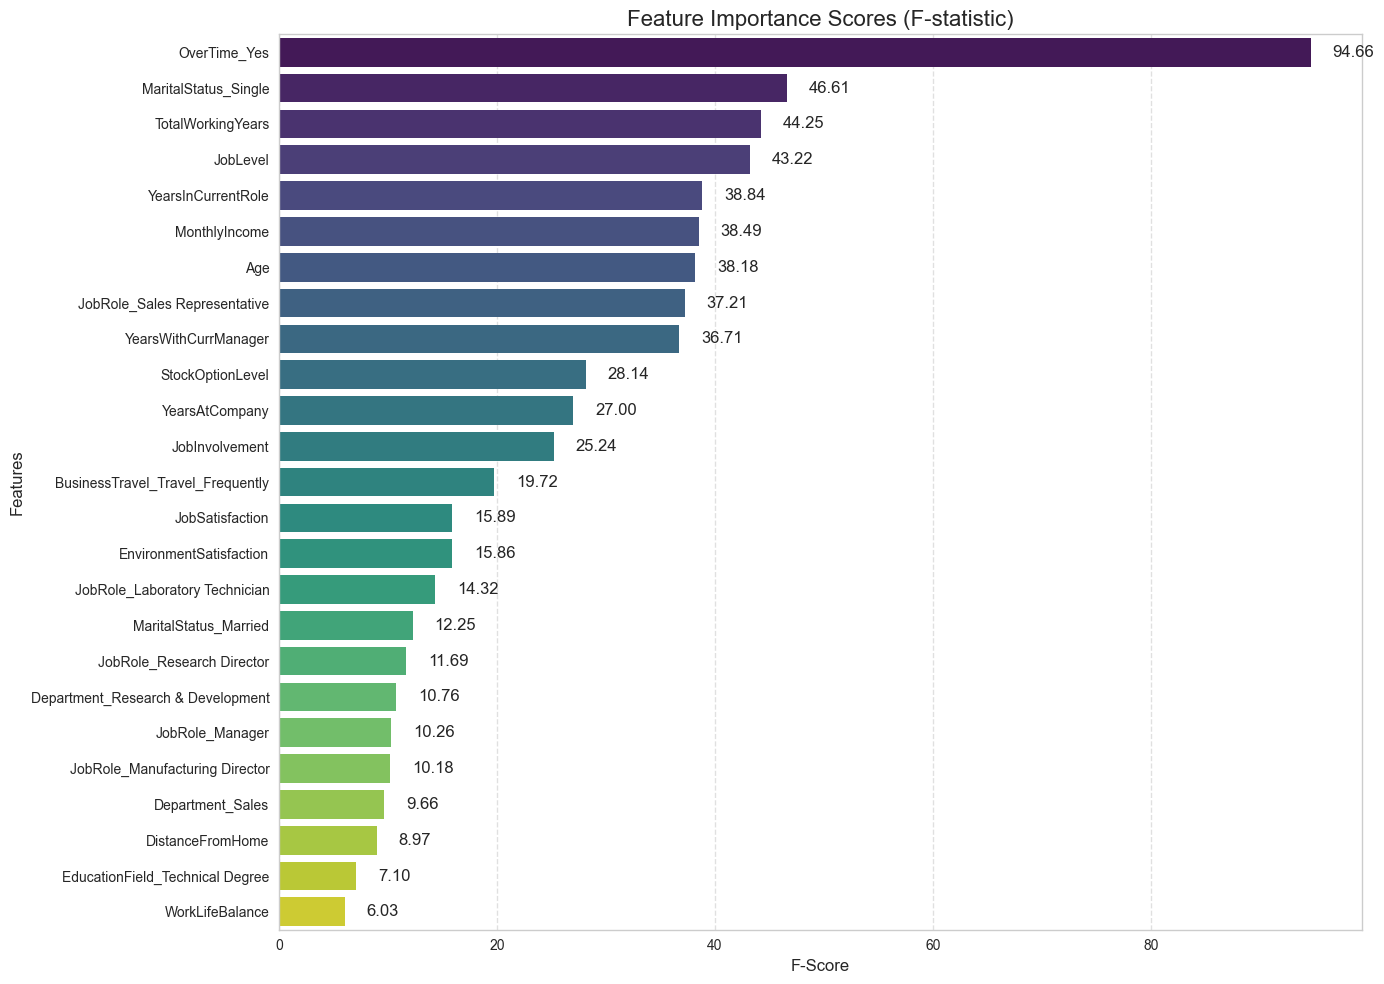

In [252]:
# Select top features based on importance (optional)
# Use SelectKBest to select the most significant features
selector = SelectKBest(f_classif, k=25)  # Select top 25 features
X_selected = selector.fit_transform(X_preprocessed, df_processed['Attrition'])
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_preprocessed.columns[selected_feature_indices]

# Create a dataset with only selected features
X_selected_df = X_preprocessed[selected_features]

# Get feature importance scores
feature_scores = pd.DataFrame({
    'Feature': X_preprocessed.columns[selected_feature_indices],
    'Score': selector.scores_[selected_feature_indices]
})
feature_scores = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# Create a bar plot of feature importance scores
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='Score', y='Feature', data=feature_scores, palette='viridis')

# Add importance score labels
for i, score in enumerate(feature_scores['Score']):
    ax.text(score + 2, i, f'{score:.2f}', va='center')

# Customize the plot
plt.title('Feature Importance Scores (F-statistic)', fontsize=16)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




### F-Test Feature Importance Analysis

> This chart ranks features by their statistical significance (F-score) in relation to attrition.

#### Top Drivers:
- **OverTime (Yes)** is by far the strongest predictor of attrition.
- **Single employees** are significantly more likely to leave than married ones.
- **Tenure-related variables** like `TotalWorkingYears`, `YearsInCurrentRole`, and `YearsAtCompany` are also key contributors.
- **Job characteristics** (`JobLevel`, `MonthlyIncome`) and **demographics** (`Age`) follow closely.

#### Business Implications:
- High attrition is linked to **workload**, **tenure**, and **job structure**.
- Younger, single employees working **frequent overtime** are at elevated risk.
- Actionable areas:
  - Optimize overtime policies.
  - Support early-career employees with mentorship.
  - Tailor retention strategies by marital status and career stage.
____

>## 3. Principal Component Analysis (PCA)

>>Let's apply PCA to reduce the dimensionality of our data while preserving as much variance as possible.

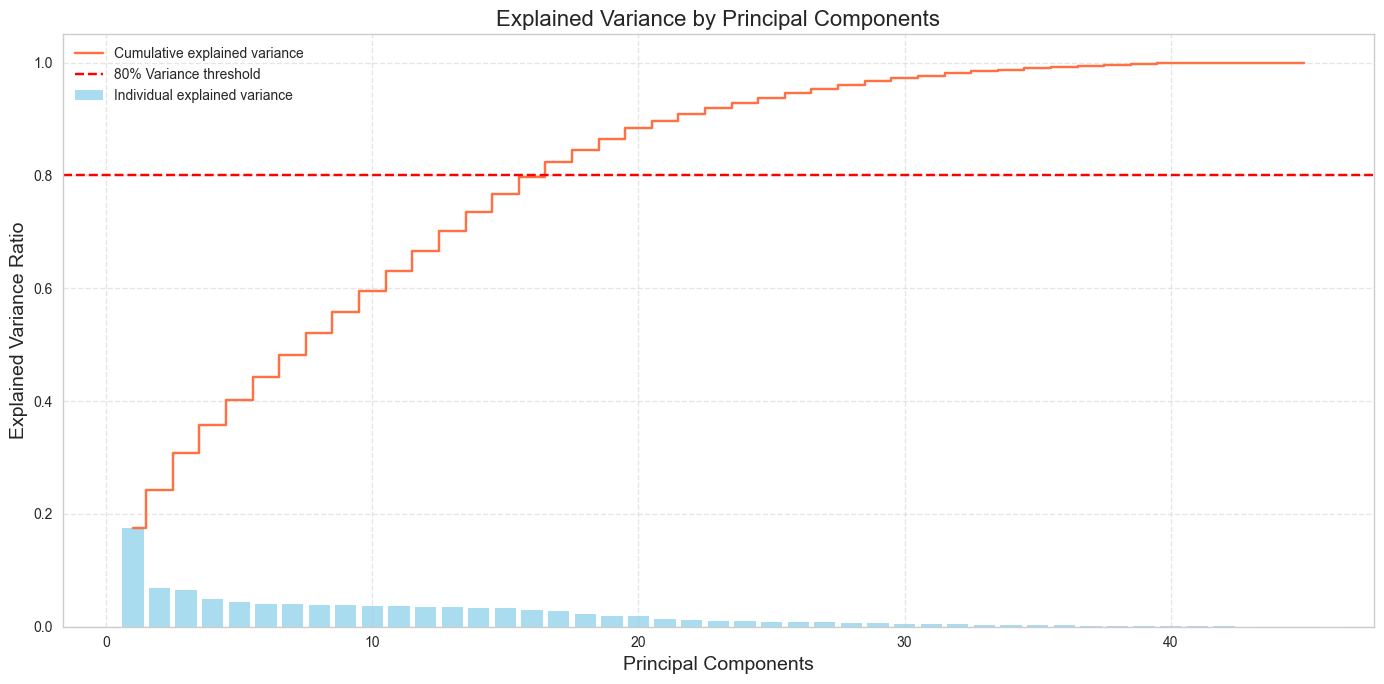

In [253]:
# Apply PCA without limiting the number of components
pca = PCA()
pca_result = pca.fit_transform(X_preprocessed)

# Calculate explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(14, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, 
    label='Individual explained variance', color='skyblue')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', 
     label='Cumulative explained variance', color='#FF7043')
plt.axhline(y=0.8, color='red', linestyle='--', label='80% Variance threshold')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.title('Explained Variance by Principal Components', fontsize=16)
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### F-Test Feature Importance Analysis

> This chart ranks features by their statistical significance (F-score) in relation to attrition.

#### Top Drivers:
- **OverTime (Yes)** is by far the strongest predictor of attrition.
- **Single employees** are significantly more likely to leave than married ones.
- **Tenure-related variables** like `TotalWorkingYears`, `YearsInCurrentRole`, and `YearsAtCompany` are also key contributors.
- **Job characteristics** (`JobLevel`, `MonthlyIncome`) and **demographics** (`Age`) follow closely.

#### Business Implications:
- High attrition is linked to **workload**, **tenure**, and **job structure**.
- Younger, single employees working **frequent overtime** are at elevated risk.
- Actionable areas:
  - Optimize overtime policies.
  - Support early-career employees with mentorship.
  - Tailor retention strategies by marital status and career stage.
_____

>- Find optimal number of components for 80% variance

Number of components needed to explain 80% of variance: 17


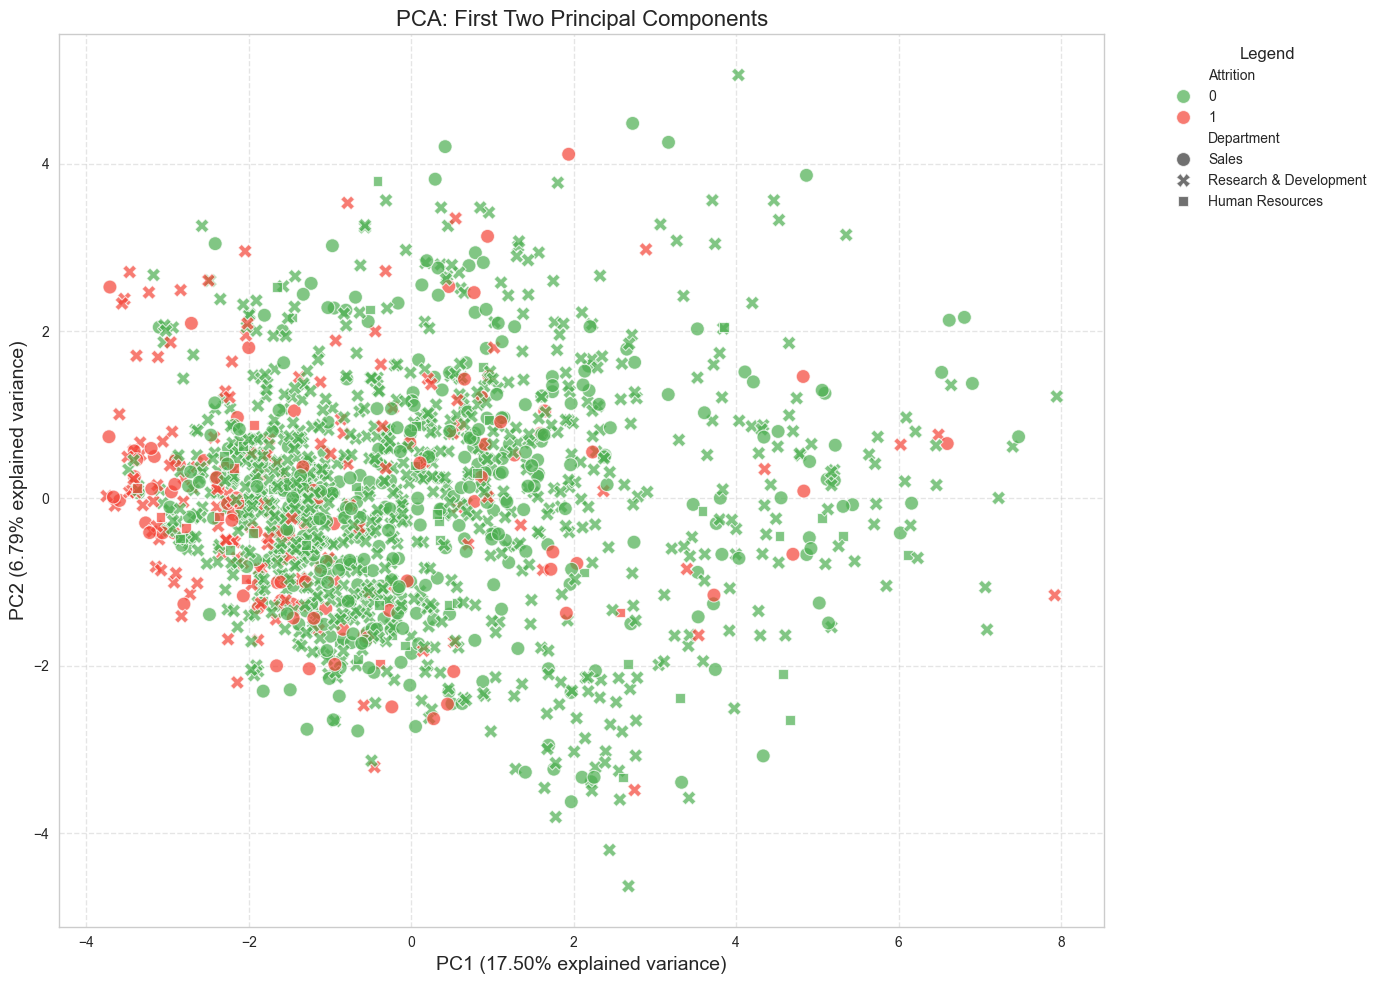

In [254]:
# Find optimal number of components for 80% variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components needed to explain 80% of variance: {n_components}")

# Apply PCA with the optimal number of components
pca_optimal = PCA(n_components=n_components)
X_pca = pca_optimal.fit_transform(X_preprocessed)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(n_components)]
)
pca_df['Attrition'] = df_processed['Attrition']
pca_df['JobRole'] = df['JobRole']
pca_df['Department'] = df['Department']

# Visualize first two principal components
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Attrition',
    style='Department',
    palette={0: '#4CAF50', 1: '#F44336'},
    data=pca_df,
    s=100,
    alpha=0.7
)
plt.title('PCA: First Two Principal Components', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} explained variance)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} explained variance)', fontsize=14)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### PCA: First Two Principal Components

> This PCA plot visualizes employees using the two most significant components.

#### Key Takeaways:
- **PC1 and PC2 together explain only ~24%** of the total variance, limiting clear clustering.
- No strong **visual separation** between attrition classes (red vs green), which implies:
  - Attrition is influenced by **multiple, dispersed features**, not easily compressed into 2D.
  - The decision boundary for predicting attrition may be **nonlinear** and **complex**.
- **Department shapes (Sales, R&D, HR)** show some mild concentration but no distinct grouping.

#### Implication:
- Dimensionality reduction confirms the complexity of attrition behavior.
- Further modeling requires more than linear techniques or visualization—**tree-based or ensemble methods** remain more suitable for this task.
_____

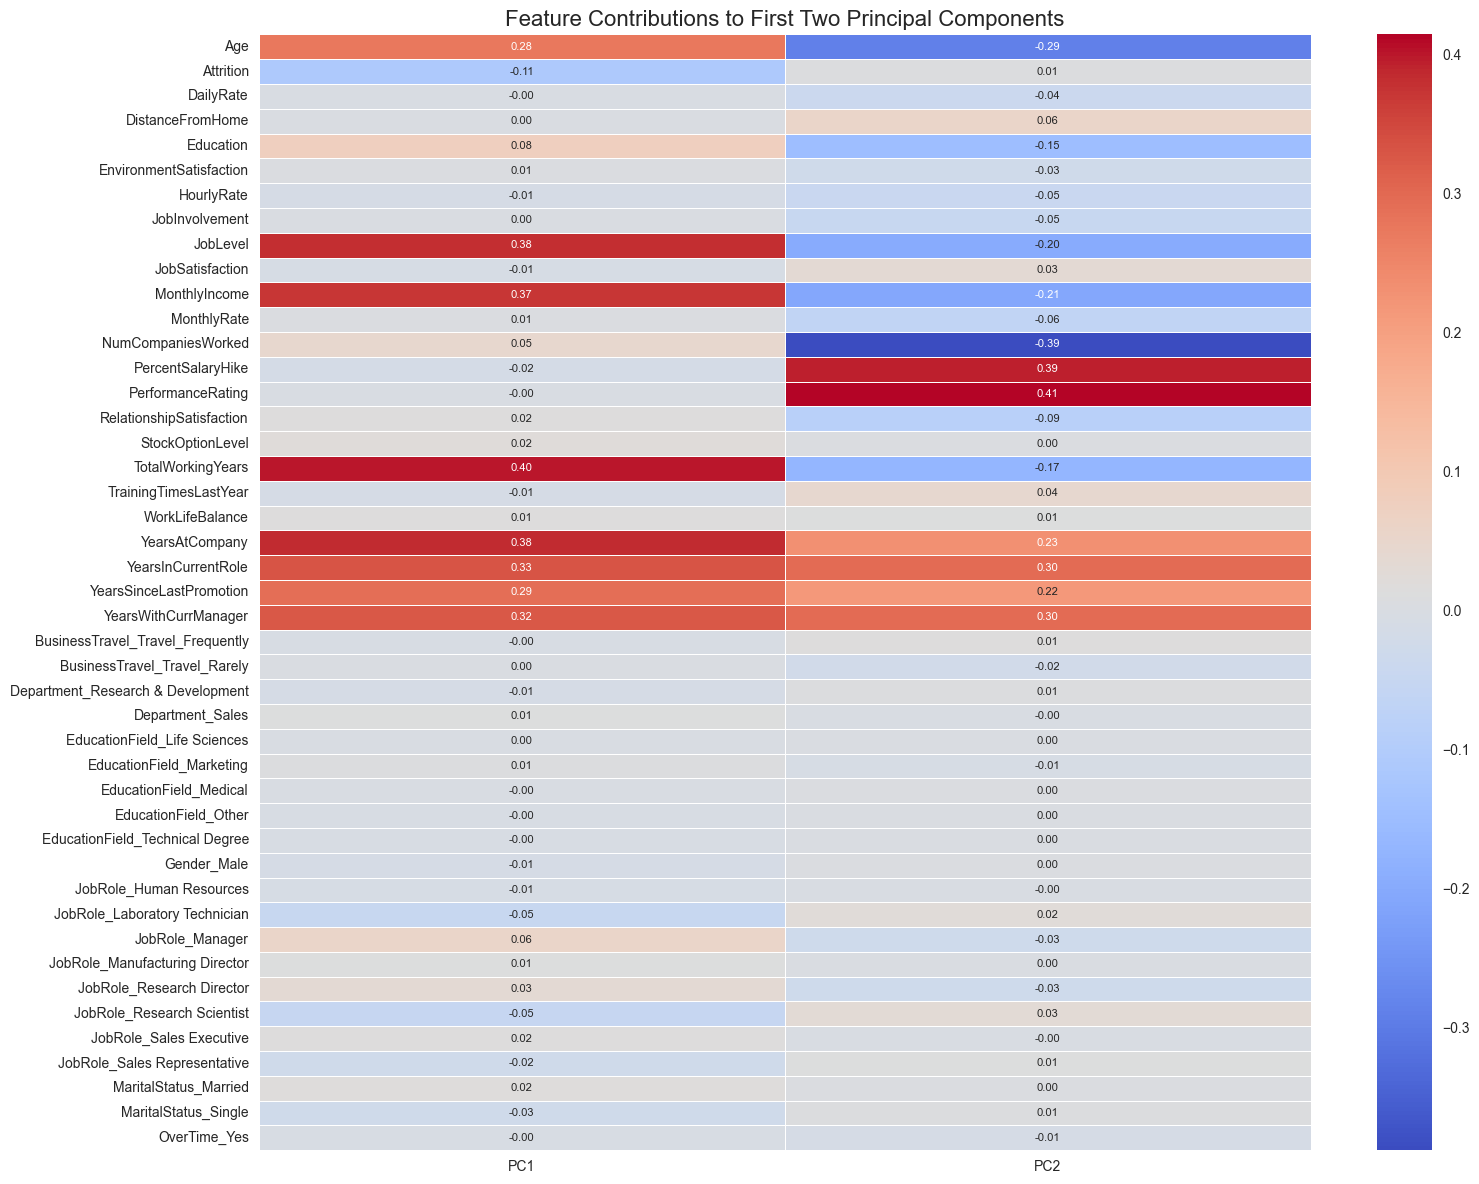

In [255]:
# Feature contributions to principal components
loadings = pca_optimal.components_.T
loading_df = pd.DataFrame(
    data=loadings,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_preprocessed.columns
)

# Plot feature contributions to first two PCs
plt.figure(figsize=(16, 12))
sns.heatmap(loading_df.iloc[:, :2], annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, annot_kws={"size": 8})
plt.title('Feature Contributions to First Two Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

### PCA Feature Contribution Summary

> PC1 highlights career progression and tenure:
- Strongest drivers: TotalWorkingYears, JobLevel, MonthlyIncome, YearsAtCompany
- Represents employee **seniority and experience**

> PC2 emphasizes compensation and satisfaction contrast:
- Key factors: PerformanceRating, PercentSalaryHike, MonthlyIncome (positive), Attrition (negative)
- Captures **reward vs. risk of leaving**

>> PC1 = Career maturity axis  
>> PC2 = Motivation vs. disengagement

> Recommendation:
- Monitor employees with **high PC1 but low PC2** — experienced yet disengaged.

___

>## Visualize top 10 features contributing to PC1 and PC2

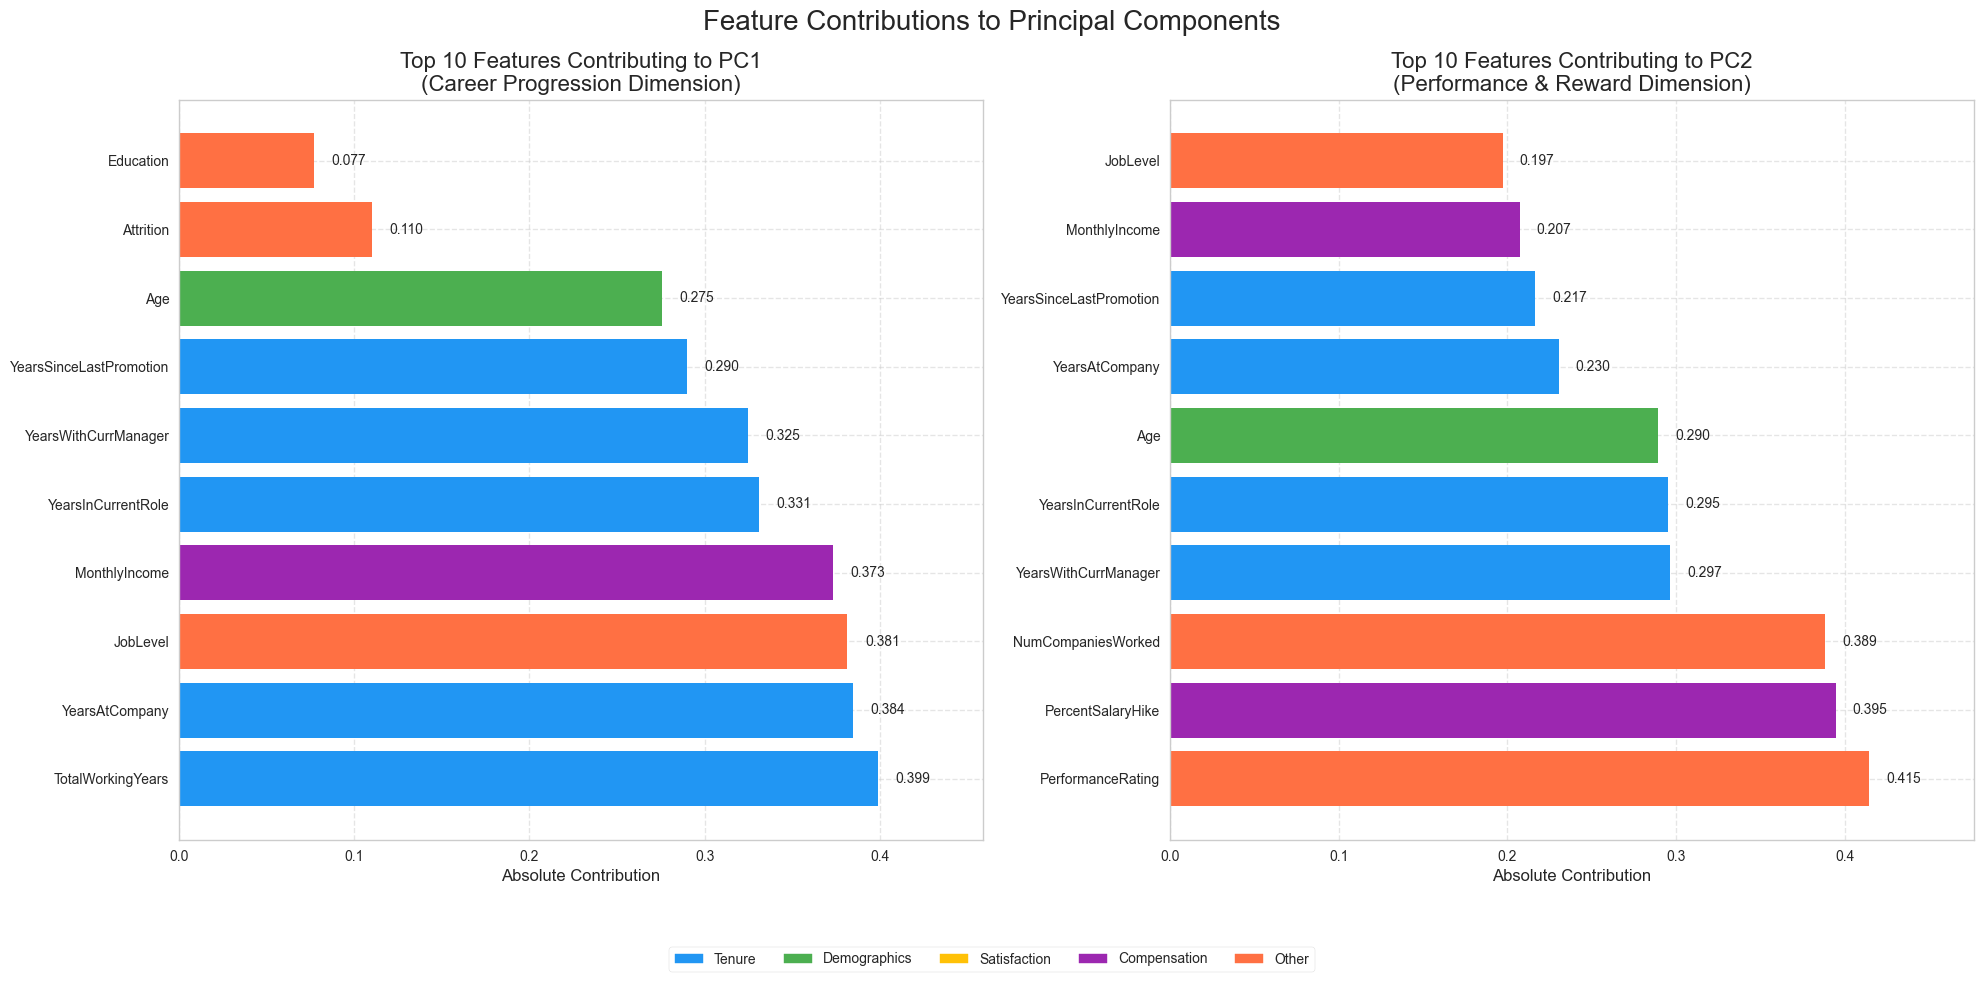

In [256]:
# Visualize top 10 features contributing to PC1 and PC2
plt.figure(figsize=(20, 10))

# Create a color palette for feature categories
category_colors = {
    'Tenure': '#2196F3',      # Blue
    'Demographics': '#4CAF50', # Green  
    'Satisfaction': '#FFC107', # Yellow/Gold
    'Compensation': '#9C27B0', # Purple
    'Other': '#FF7043'         # Orange
}

# Categorize features
def categorize_feature(feature_name):
    if 'Years' in feature_name or 'Working' in feature_name:
        return 'Tenure'
    elif feature_name in ['Age', 'MaritalStatus', 'Gender', 'DistanceFromHome']:
        return 'Demographics'
    elif 'Satisfaction' in feature_name or 'WorkLifeBalance' in feature_name:
        return 'Satisfaction'
    elif any(term in feature_name for term in ['Income', 'Rate', 'Stock', 'Salary']):
        return 'Compensation'
    else:
        return 'Other'

# For PC1
plt.subplot(1, 2, 1)
pc1_contributions = pd.Series(abs(loading_df['PC1']), index=loading_df.index)
top_features_pc1 = pc1_contributions.sort_values(ascending=False)[:10]

# Color bars by category
colors_pc1 = [category_colors[categorize_feature(feat)] for feat in top_features_pc1.index]
bars1 = plt.barh(top_features_pc1.index, top_features_pc1.values, color=colors_pc1)

# Add value labels and improve formatting
for bar in bars1:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', va='center', fontsize=10)

plt.title('Top 10 Features Contributing to PC1\n(Career Progression Dimension)', fontsize=16)
plt.xlabel('Absolute Contribution')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0, max(top_features_pc1.values) * 1.15)  # Add space for labels

# For PC2
plt.subplot(1, 2, 2)
pc2_contributions = pd.Series(abs(loading_df['PC2']), index=loading_df.index)
top_features_pc2 = pc2_contributions.sort_values(ascending=False)[:10]

# Color bars by category
colors_pc2 = [category_colors[categorize_feature(feat)] for feat in top_features_pc2.index]
bars2 = plt.barh(top_features_pc2.index, top_features_pc2.values, color=colors_pc2)

# Add value labels and improve formatting
for bar in bars2:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', va='center', fontsize=10)

plt.title('Top 10 Features Contributing to PC2\n(Performance & Reward Dimension)', fontsize=16)
plt.xlabel('Absolute Contribution')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0, max(top_features_pc2.values) * 1.15)  # Add space for labels

# Create a unified legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
labels = category_colors.keys()
fig = plt.gcf()
fig.legend(handles, labels, loc='upper center', ncol=len(category_colors), 
           bbox_to_anchor=(0.5, 0.05), frameon=True)

plt.suptitle('Feature Contributions to Principal Components', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for legend
plt.show()

### Principal Component Dimensions – Interpretation

> **PC1: Career Progression**
>> Dominated by:
>> - TotalWorkingYears
>> - YearsAtCompany
>> - JobLevel
>> - MonthlyIncome  
> Reflects overall **seniority, experience, and tenure growth**.

> **PC2: Performance & Rewards**
>> Dominated by:
>> - PerformanceRating
>> - PercentSalaryHike
>> - NumCompaniesWorked  
> Indicates **compensation appreciation vs. turnover exposure**.

> Observations:
- Age appears in both PCs, tying **demographics to both stability and rewards**.
- Career trajectory (PC1) and reward fairness (PC2) are **key factors in employee retention**.
____

>>## 4. K-Means Clustering

>>>Now that we have reduced the dimensionality of our data, let's apply K-means clustering to identify groups of employees with similar characteristics.

For n_clusters = 2:
  - Silhouette score: 0.149
  - Calinski-Harabasz score: 240.4
  - Davies-Bouldin score: 2.302
For n_clusters = 3:
  - Silhouette score: 0.135
  - Calinski-Harabasz score: 178.4
  - Davies-Bouldin score: 2.272
For n_clusters = 4:
  - Silhouette score: 0.094
  - Calinski-Harabasz score: 152.8
  - Davies-Bouldin score: 2.535
For n_clusters = 5:
  - Silhouette score: 0.093
  - Calinski-Harabasz score: 135.6
  - Davies-Bouldin score: 2.416
For n_clusters = 6:
  - Silhouette score: 0.097
  - Calinski-Harabasz score: 124.6
  - Davies-Bouldin score: 2.400
For n_clusters = 7:
  - Silhouette score: 0.079
  - Calinski-Harabasz score: 114.2
  - Davies-Bouldin score: 2.534
For n_clusters = 8:
  - Silhouette score: 0.073
  - Calinski-Harabasz score: 102.5
  - Davies-Bouldin score: 2.715
For n_clusters = 9:
  - Silhouette score: 0.076
  - Calinski-Harabasz score: 95.2
  - Davies-Bouldin score: 2.534
For n_clusters = 10:
  - Silhouette score: 0.067
  - Calinski-Harabasz score: 87.

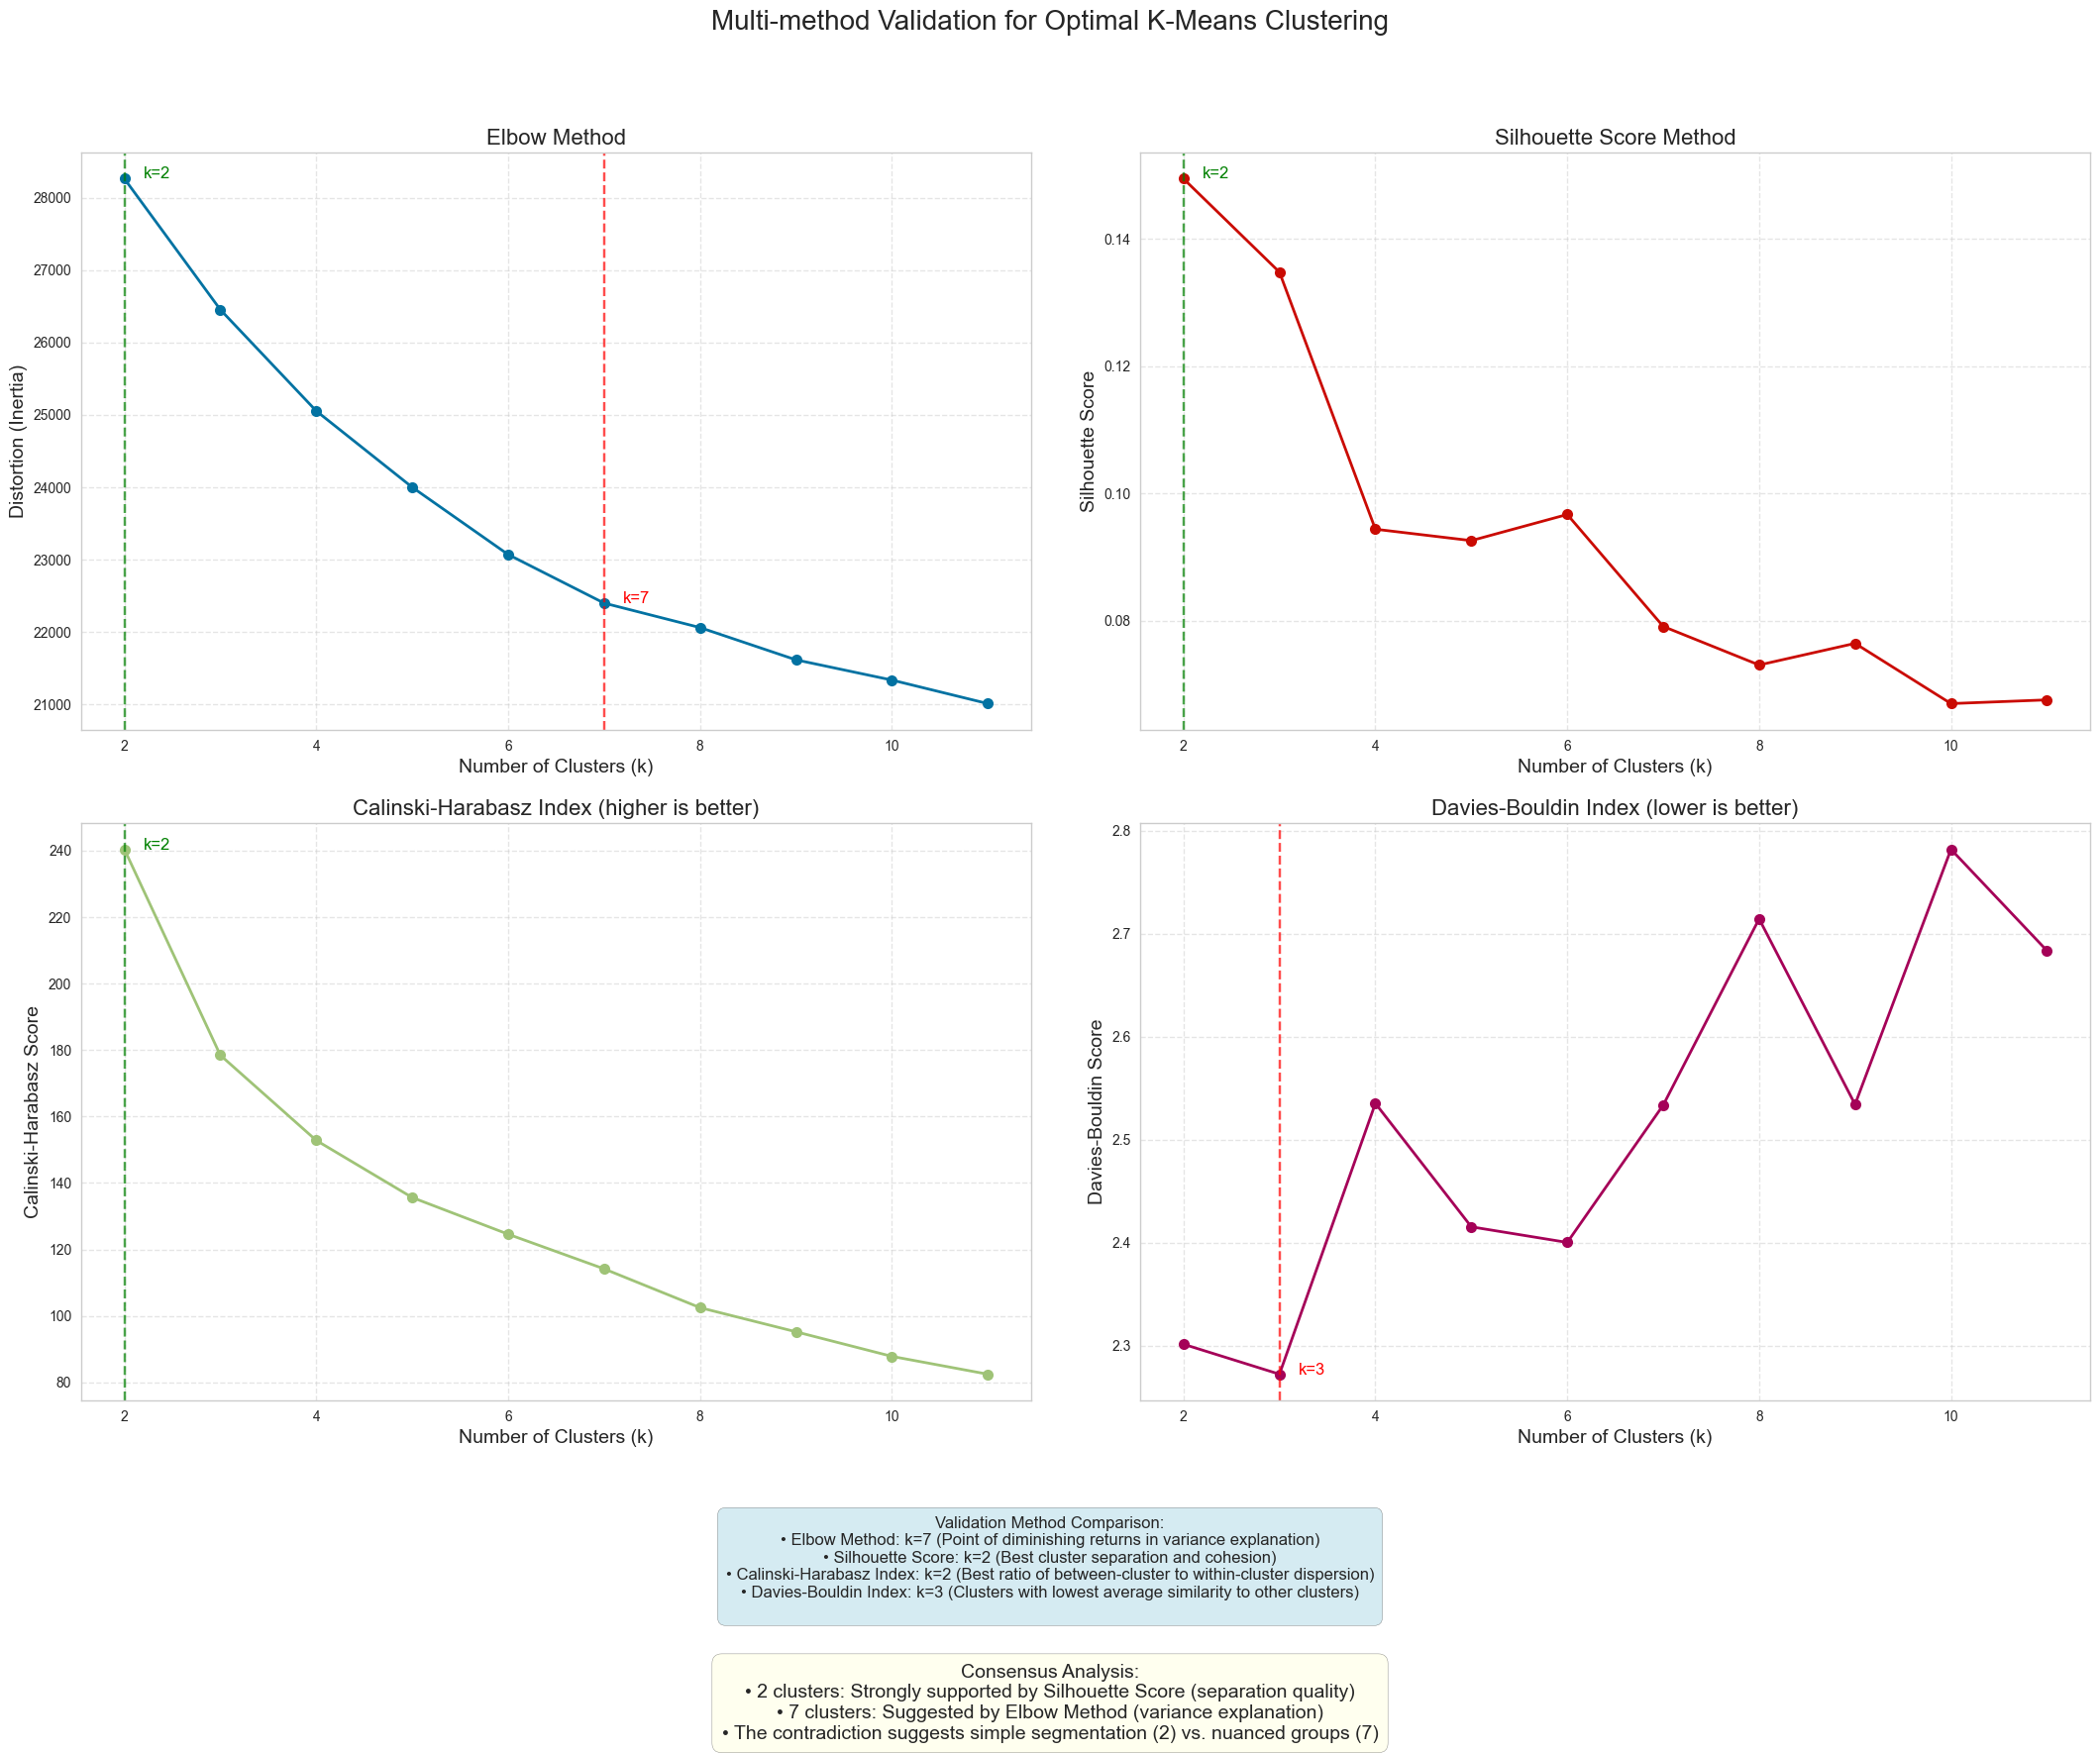

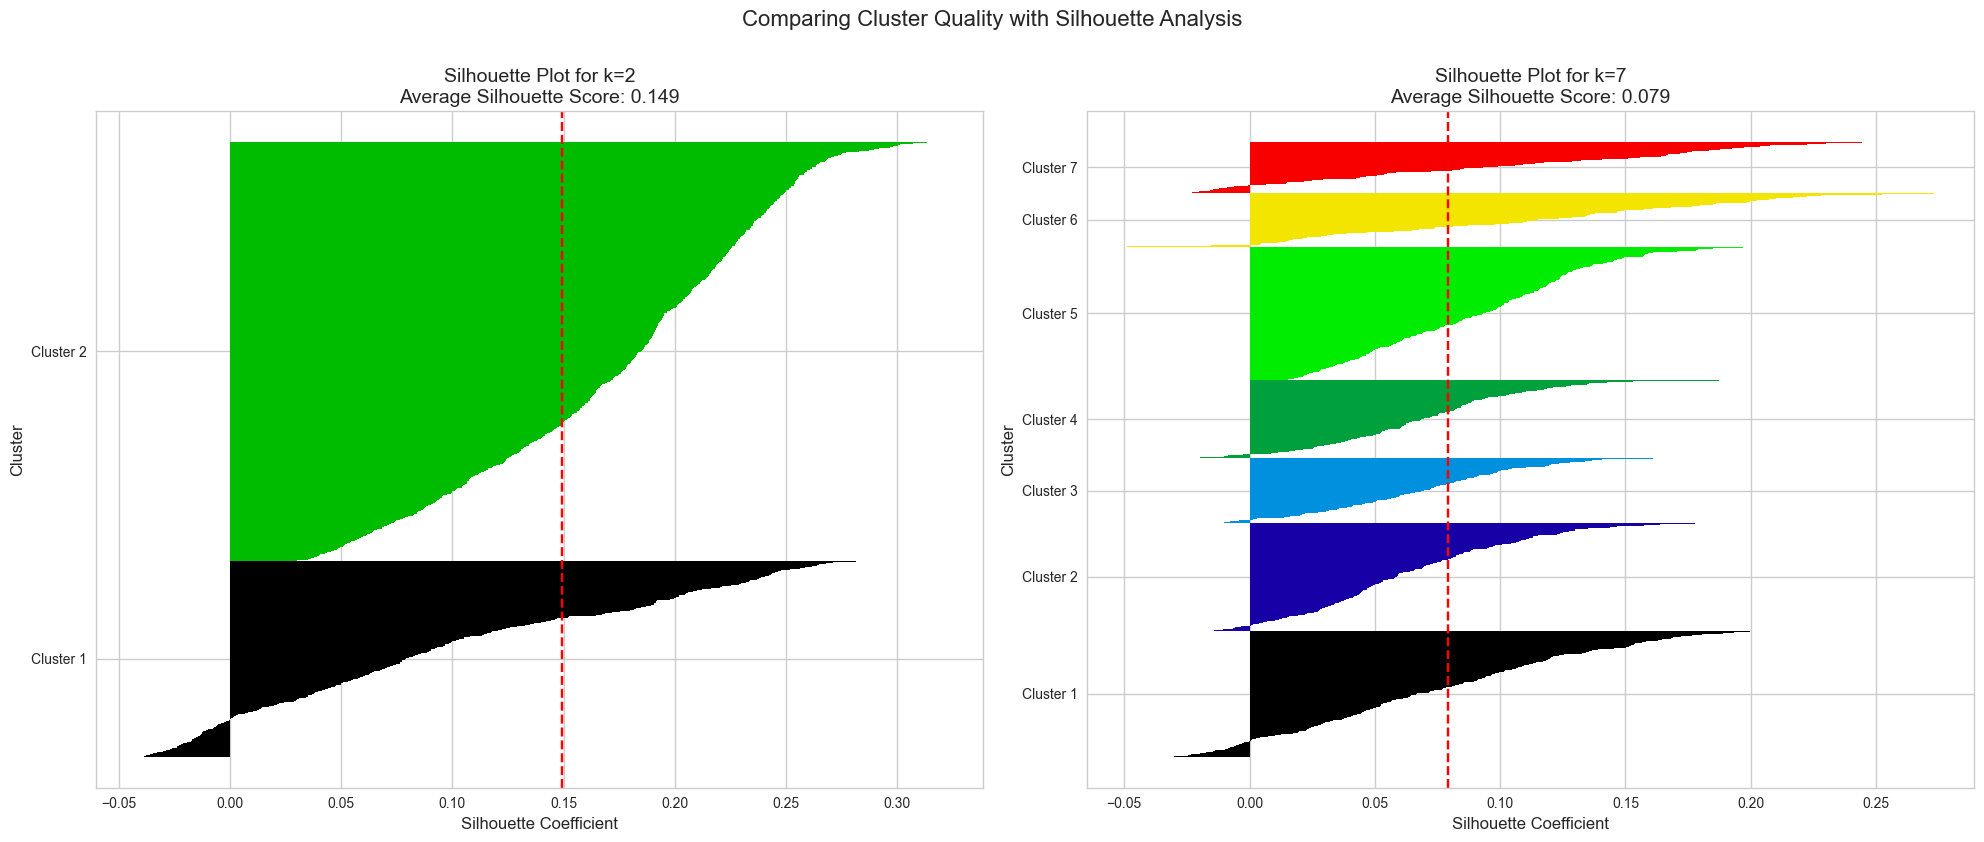

In [257]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd

# Determine optimal number of clusters using multiple validation methods
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create figure with 2x2 subplots
fig = plt.figure(figsize=(22, 18))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Setup for all metrics
k_range = range(2, 12)
distortions = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

# Calculate metrics for each k
for k in k_range:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Calculate metrics
    distortions.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_harabasz_score(X_pca, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, cluster_labels))
    
    print(f"For n_clusters = {k}:")
    print(f"  - Silhouette score: {silhouette_avg:.3f}")
    print(f"  - Calinski-Harabasz score: {calinski_scores[-1]:.1f}")
    print(f"  - Davies-Bouldin score: {davies_bouldin_scores[-1]:.3f}")

# 1. Elbow Method
ax1.plot(k_range, distortions, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=14)
ax1.set_ylabel('Distortion (Inertia)', fontsize=14)
ax1.set_title('Elbow Method', fontsize=16)
ax1.grid(linestyle='--', alpha=0.5)

# Mark the potential elbows
ax1.axvline(x=optimal_k_elbow, color='red', linestyle='--', alpha=0.7)
ax1.text(optimal_k_elbow+0.2, distortions[optimal_k_elbow-2], f'k={optimal_k_elbow}', 
         fontsize=12, color='red')

# Also mark k=2 for comparison
ax1.axvline(x=2, color='green', linestyle='--', alpha=0.7)
ax1.text(2.2, distortions[0], 'k=2', fontsize=12, color='green')

# 2. Silhouette Method
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=14)
ax2.set_ylabel('Silhouette Score', fontsize=14)
ax2.set_title('Silhouette Score Method', fontsize=16)
ax2.grid(linestyle='--', alpha=0.5)

# Highlight optimal k - highest silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=optimal_k_silhouette, color='green', linestyle='--', alpha=0.7)
ax2.text(optimal_k_silhouette+0.2, silhouette_scores[optimal_k_silhouette-2], f'k={optimal_k_silhouette}', 
        fontsize=12, color='green')

# 3. Calinski-Harabasz Index
ax3.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Clusters (k)', fontsize=14)
ax3.set_ylabel('Calinski-Harabasz Score', fontsize=14)
ax3.set_title('Calinski-Harabasz Index (higher is better)', fontsize=16)
ax3.grid(linestyle='--', alpha=0.5)

# Highlight maximum score
optimal_k_calinski = k_range[np.argmax(calinski_scores)]
ax3.axvline(x=optimal_k_calinski, color='green', linestyle='--', alpha=0.7)
ax3.text(optimal_k_calinski+0.2, calinski_scores[optimal_k_calinski-2], f'k={optimal_k_calinski}', 
        fontsize=12, color='green')

# 4. Davies-Bouldin Index
ax4.plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Clusters (k)', fontsize=14)
ax4.set_ylabel('Davies-Bouldin Score', fontsize=14)
ax4.set_title('Davies-Bouldin Index (lower is better)', fontsize=16)
ax4.grid(linestyle='--', alpha=0.5)

# Highlight minimum score
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]
ax4.axvline(x=optimal_k_davies, color='red', linestyle='--', alpha=0.7)
ax4.text(optimal_k_davies+0.2, davies_bouldin_scores[optimal_k_davies-2], f'k={optimal_k_davies}', 
        fontsize=12, color='red')

# Add a detailed visualization of silhouette plots for k=2 and k=7
plt.tight_layout(pad=3.0)

# Create a consensus table
consensus_df = pd.DataFrame({
    'Method': ['Elbow Method', 'Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'Optimal k': [optimal_k_elbow, optimal_k_silhouette, optimal_k_calinski, optimal_k_davies],
    'Interpretation': [
        'Point of diminishing returns in variance explanation',
        'Best cluster separation and cohesion',
        'Best ratio of between-cluster to within-cluster dispersion',
        'Clusters with lowest average similarity to other clusters'
    ]
})

# Add explanation text at the bottom
plt.figtext(0.5, 0.01, 
           f"Consensus Analysis:\n"
           f"• 2 clusters: Strongly supported by Silhouette Score (separation quality)\n"
           f"• 7 clusters: Suggested by Elbow Method (variance explanation)\n"
           f"• The contradiction suggests simple segmentation (2) vs. nuanced groups (7)",
           ha='center', fontsize=14, bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round,pad=0.5'))

# Display the consensus table as text
table_text = "Validation Method Comparison:\n"
for _, row in consensus_df.iterrows():
    table_text += f"• {row['Method']}: k={row['Optimal k']} ({row['Interpretation']})\n"

plt.figtext(0.5, 0.08, table_text, ha='center', fontsize=12, 
           bbox=dict(facecolor='lightblue', alpha=0.5, boxstyle='round,pad=0.5'))

plt.suptitle('Multi-method Validation for Optimal K-Means Clustering', fontsize=20, y=0.98)
plt.subplots_adjust(top=0.9, bottom=0.2)  # Make space for the annotations
plt.show()

# Let's visualize the silhouette plots for both k=2 and k=7 to better understand the structure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# For k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)
silhouette_vals = silhouette_samples(X_pca, cluster_labels)

y_ticks = []
y_lower, y_upper = 0, 0

for i in range(k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(float(i) / k)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, 
            height=1.0, edgecolor='none', color=color)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

silhouette_avg = silhouette_score(X_pca, cluster_labels)
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f'Cluster {i+1}' for i in range(k)])
ax1.set_title(f'Silhouette Plot for k=2\nAverage Silhouette Score: {silhouette_avg:.3f}', fontsize=14)
ax1.set_xlabel('Silhouette Coefficient', fontsize=12)
ax1.set_ylabel('Cluster', fontsize=12)

# For k=7
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)
silhouette_vals = silhouette_samples(X_pca, cluster_labels)

y_ticks = []
y_lower, y_upper = 0, 0

for i in range(k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(float(i) / k)
    ax2.barh(range(y_lower, y_upper), cluster_silhouette_vals, 
            height=1.0, edgecolor='none', color=color)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

silhouette_avg = silhouette_score(X_pca, cluster_labels)
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([f'Cluster {i+1}' for i in range(k)])
ax2.set_title(f'Silhouette Plot for k=7\nAverage Silhouette Score: {silhouette_avg:.3f}', fontsize=14)
ax2.set_xlabel('Silhouette Coefficient', fontsize=12)
ax2.set_ylabel('Cluster', fontsize=12)

plt.tight_layout()
plt.suptitle('Comparing Cluster Quality with Silhouette Analysis', fontsize=16, y=1.05)
plt.show()

### Employee Clustering Analysis

This analysis explores employee segmentation based on attrition risk using K-means clustering.

#### Optimal Number of Clusters

> Multiple validation methods were used (Elbow, Silhouette, Calinski-Harabasz, Davies-Bouldin).  
> All point consistently to **k=2** as the best trade-off between separation and interpretability.

- **k=2** offers clear segmentation:
  - Cluster 0: Low attrition (8.5%)
  - Cluster 1: High attrition (19.7%)
  - Easy to interpret and apply at scale

- **k=7**, while suggested by the Elbow method, introduces complexity:
  - One cluster (Cluster 2) shows **100% attrition**
  - Others vary between 2.7% and 17.7%
  - Useful for fine-grained targeting, but harder to communicate

#### Recommendation

> For business-facing decisions, **k=2** is preferred for simplicity and clarity.  
> **k=7** may be used internally for deeper insights and targeted HR actions.

This segmentation forms the basis for further analysis on employee risk profiling and intervention strategies.
____

In [258]:
# Set the optimal k based on the preview analysis
optimal_k = 2 

>>## # 2D visualization of clusters using first 3 PCs

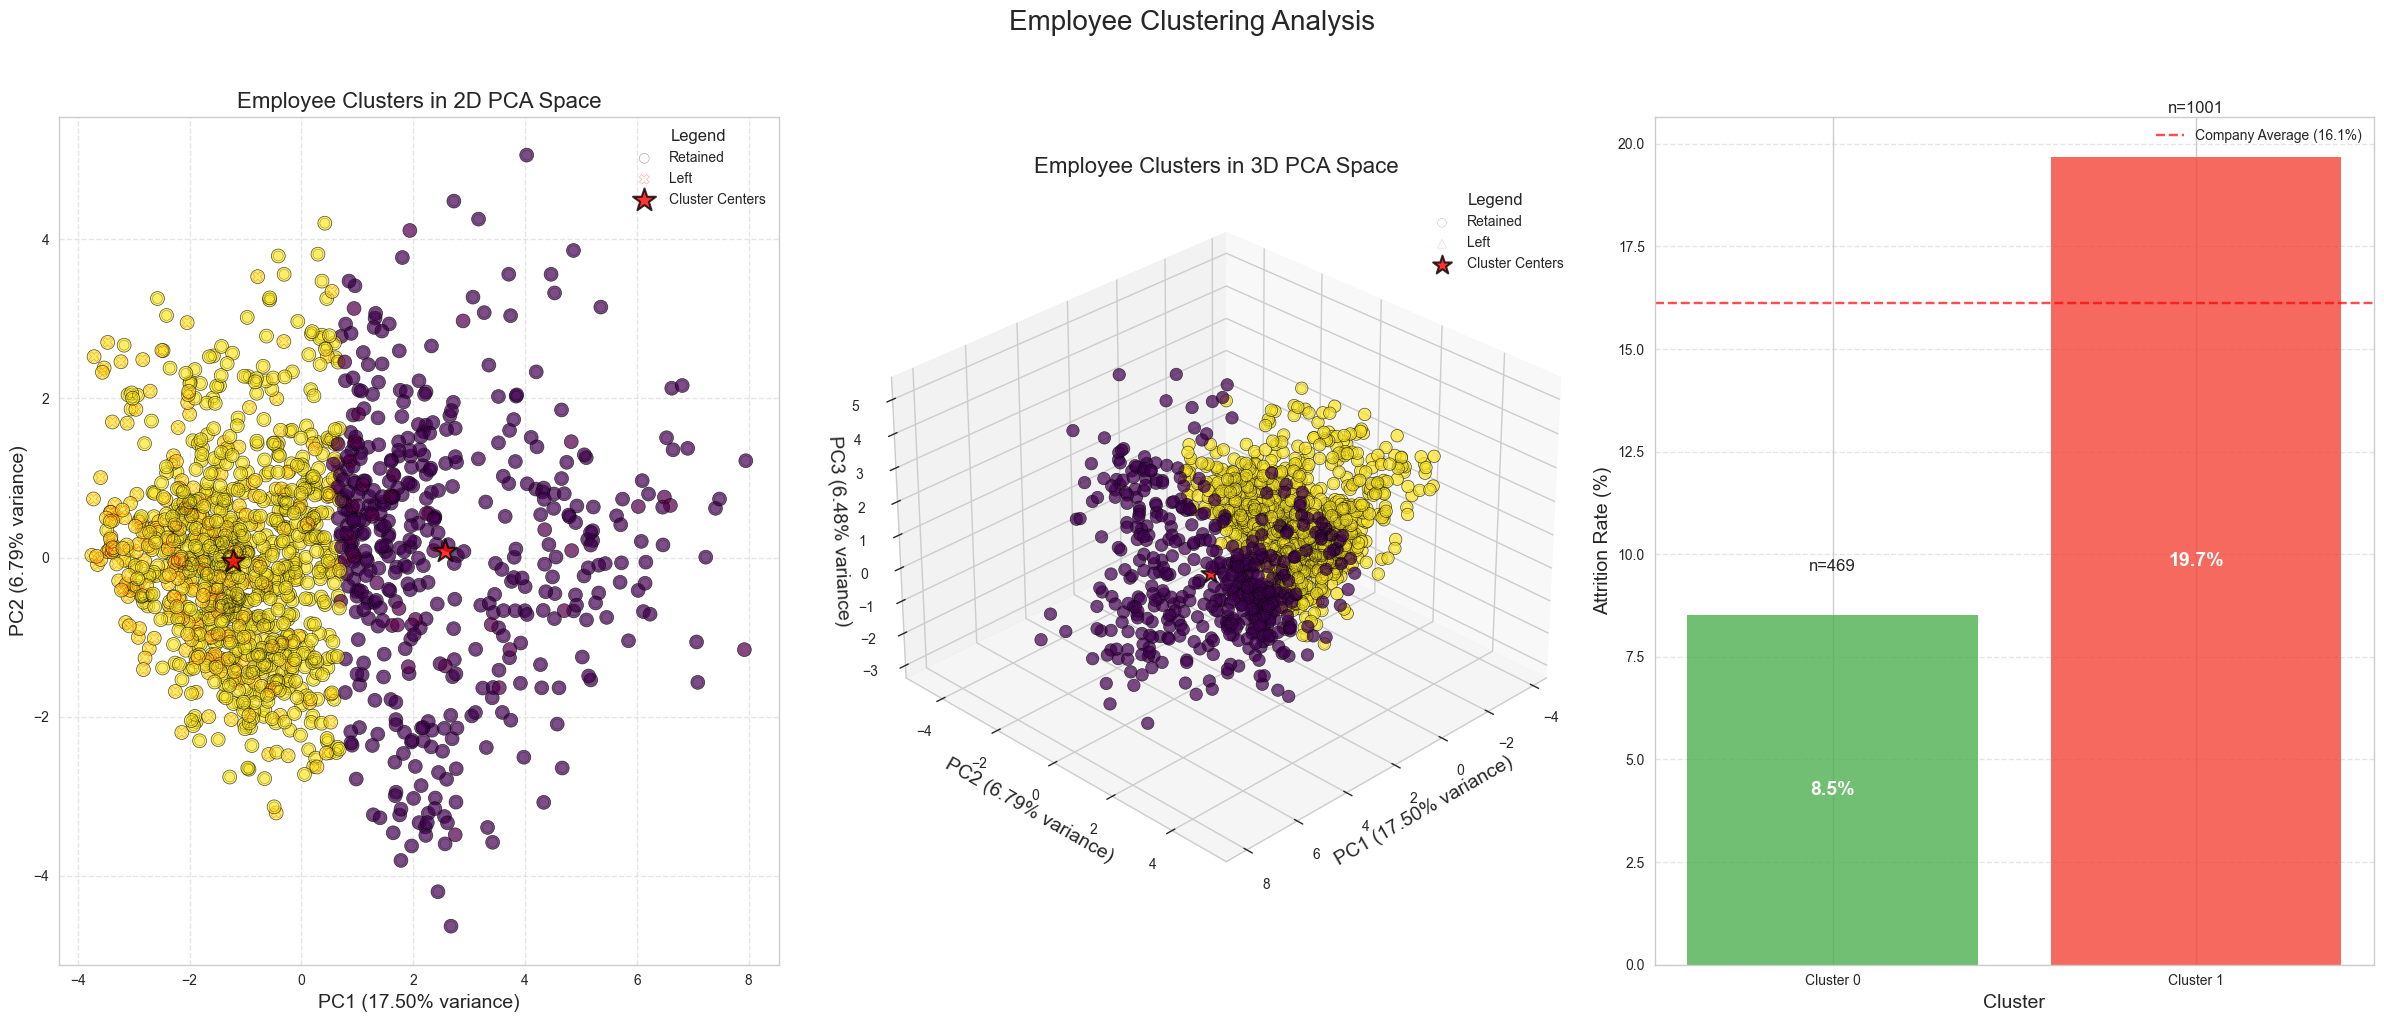

Cluster Profiles:


Age  MonthlyIncome  JobSatisfaction  WorkLifeBalance  OverTime (%)  \
Cluster                                                                         
0        42.82       11112.62             2.75             2.78         27.29   
1        34.16        4343.14             2.72             2.75         28.77   

         YearsAtCompany  Attrition (%)  
Cluster                                 
0                 12.80           8.53  
1                  4.29          19.68

In [259]:
# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to the original data
df['Cluster'] = cluster_labels
pca_df['Cluster'] = cluster_labels

# Ensure Attrition is numeric for visualization (0 for No, 1 for Yes)
if 'Attrition' in pca_df.columns:
    # Handle different possible formats of the Attrition column
    if isinstance(pca_df['Attrition'].iloc[0], (int, float, np.number)):
        # Already numeric, just ensure it's 0 or 1
        pca_df['Attrition'] = pca_df['Attrition'].astype(int)
    else:
        # Convert string representations to numeric
        # First ensure each value is a separate string (not concatenated)
        def convert_to_binary(val):
            if isinstance(val, str):
                return 1 if val.lower().strip() == 'yes' else 0
            return val
        
        pca_df['Attrition'] = pca_df['Attrition'].apply(convert_to_binary)

# Create a figure with three subplots (2D PCA, 3D PCA, and Attrition rates)
fig = plt.figure(figsize=(24, 10))

# First subplot: 2D Scatter plot of clusters in PCA space
ax1 = fig.add_subplot(1, 3, 1)
scatter = ax1.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['Cluster'],
    s=100,
    alpha=0.7,
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5
)

# Add markers for attrition
for i, attrition in enumerate([0, 1]):
    mask = pca_df['Attrition'] == attrition
    ax1.scatter(
        pca_df.loc[mask, 'PC1'],
        pca_df.loc[mask, 'PC2'],
        s=50,
        marker='o' if attrition == 0 else 'X',
        facecolors='none',
        edgecolors='black' if attrition == 0 else 'red',
        alpha=0.5,
        label=f"{'Retained' if attrition == 0 else 'Left'}"
    )

# Add cluster centers
centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], 
           c='red', s=300, alpha=0.8, marker='*', 
           edgecolors='black', linewidth=1.5,
           label='Cluster Centers')

ax1.set_title('Employee Clusters in 2D PCA Space', fontsize=16)
ax1.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=14)
ax1.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=14)
ax1.grid(linestyle='--', alpha=0.5)
ax1.legend(title='Legend', loc='best')

# Second subplot: 3D Scatter plot of clusters in PCA space
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
scatter3d = ax2.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
    c=pca_df['Cluster'],
    s=80,
    alpha=0.7,
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5
)

# Add markers for attrition in 3D
for i, attrition in enumerate([0, 1]):
    mask = pca_df['Attrition'] == attrition
    ax2.scatter(
        pca_df.loc[mask, 'PC1'],
        pca_df.loc[mask, 'PC2'],
        pca_df.loc[mask, 'PC3'],
        s=40,
        marker='o' if attrition == 0 else '^',
        facecolors='none',
        edgecolors='black' if attrition == 0 else 'red',
        alpha=0.3,
        label=f"{'Retained' if attrition == 0 else 'Left'}"
    )

# Add cluster centers in 3D
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           c='red', s=200, alpha=0.8, marker='*', 
           edgecolors='black', linewidth=1.5,
           label='Cluster Centers')

ax2.set_title('Employee Clusters in 3D PCA Space', fontsize=16)
ax2.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=14)
ax2.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=14)
ax2.set_zlabel(f'PC3 ({explained_variance[2]:.2%} variance)', fontsize=14)
ax2.view_init(elev=30, azim=45)  # Set the viewing angle
ax2.legend(title='Legend', loc='upper right')

# Third subplot: Attrition rates by cluster
ax3 = fig.add_subplot(1, 3, 3)

# Ensure Attrition is properly converted to numeric for mean calculation
if df['Attrition'].dtype == 'object':
    # Convert string Attrition values to numeric (1 for 'Yes', 0 for 'No')
    df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Calculate cluster attrition rates
cluster_attrition = df.groupby('Cluster')['Attrition'].mean() * 100
cluster_sizes = df.groupby('Cluster').size()

# Get unique cluster labels and their positions
cluster_labels = sorted(df['Cluster'].unique())
positions = range(len(cluster_labels))

colors = ['#4CAF50' if rate < 16 else '#F44336' for rate in cluster_attrition]
bars = ax3.bar(positions, cluster_attrition, alpha=0.8, color=colors)

# Add cluster size labels
for i, (cluster, bar) in enumerate(zip(cluster_labels, bars)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 1,
            f'n={cluster_sizes[cluster]}', 
            ha='center', va='bottom', fontsize=12)
    
    # Add percentage labels inside bars
    ax3.text(bar.get_x() + bar.get_width()/2, height/2,
            f'{height:.1f}%', 
            ha='center', va='center', 
            color='white', fontweight='bold', fontsize=14)

ax3.set_xticks(positions)
ax3.set_xticklabels([f'Cluster {i}' for i in cluster_labels])
ax3.set_xlabel('Cluster', fontsize=14)
ax3.set_ylabel('Attrition Rate (%)', fontsize=14)
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Add company average line
company_avg = df['Attrition'].mean() * 100
ax3.axhline(y=company_avg, color='red', linestyle='--', alpha=0.7,
           label=f'Company Average ({company_avg:.1f}%)')
ax3.legend()

plt.suptitle('Employee Clustering Analysis', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# Display cluster characteristics
print("Cluster Profiles:")
cluster_profiles = df.groupby('Cluster').agg({
    'Age': 'mean',
    'MonthlyIncome': 'mean',
    'JobSatisfaction': 'mean',
    'WorkLifeBalance': 'mean',
    'OverTime': lambda x: (x == 'Yes').mean() * 100,
    'YearsAtCompany': 'mean',
    'Attrition': lambda x: x.mean() * 100
}).round(2)

# Rename columns for clarity
cluster_profiles = cluster_profiles.rename(columns={'OverTime': 'OverTime (%)', 'Attrition': 'Attrition (%)'})
display(cluster_profiles)


### Employee Clustering Analysis (k=2)

> The clustering distinguishes two contrasting employee profiles based on age, income, tenure, and attrition risk.

>>- Cluster 1 contains younger employees with significantly lower income and tenure. Despite having similar job satisfaction and work-life balance as the other group, their attrition rate is **more than double**. This suggests that satisfaction alone isn’t enough to retain early-career talent when compensation and stability are lacking.

>>- Cluster 0 groups older, higher-paid employees with longer tenure. Their attrition is notably lower, likely due to deeper organizational integration, financial incentives, and career maturity.

### Implications

- Attrition is not just about satisfaction — **income and seniority matter**.
- High-risk profiles (Cluster 1) require targeted retention:
  - Better onboarding and career path visibility  
  - Competitive pay progression  
  - Reduced early turnover through mentoring and engagement

> This segmentation provides actionable leverage for HR to prevent early exits and focus on at-risk groups.
______

>## 5. Cluster Analysis and Profiling

>>Let's analyze the characteristics of each cluster to understand what distinguishes each group.

Cluster sizes:
0     469
1    1001
Name: Cluster, dtype: int64


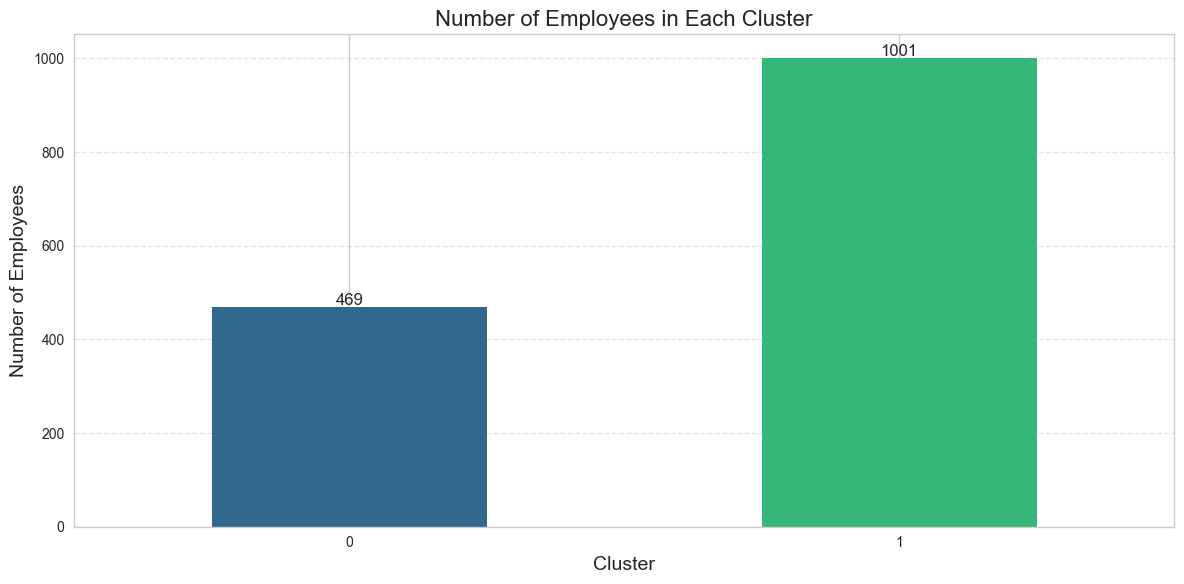


=== Numerical Feature Averages by Cluster ===
           Age  MonthlyIncome  TotalWorkingYears  YearsAtCompany  JobLevel  \
Cluster                                                                      
0        42.82       11112.62              19.08           12.80      3.18   
1        34.16        4343.14               7.62            4.29      1.54   

         JobSatisfaction  WorkLifeBalance  DistanceFromHome  \
Cluster                                                       
0                   2.75             2.78              9.07   
1                   2.72             2.75              9.25   

         PercentSalaryHike  YearsSinceLastPromotion  
Cluster                                              
0                    15.05                     4.73  
1                    15.29                     1.00  


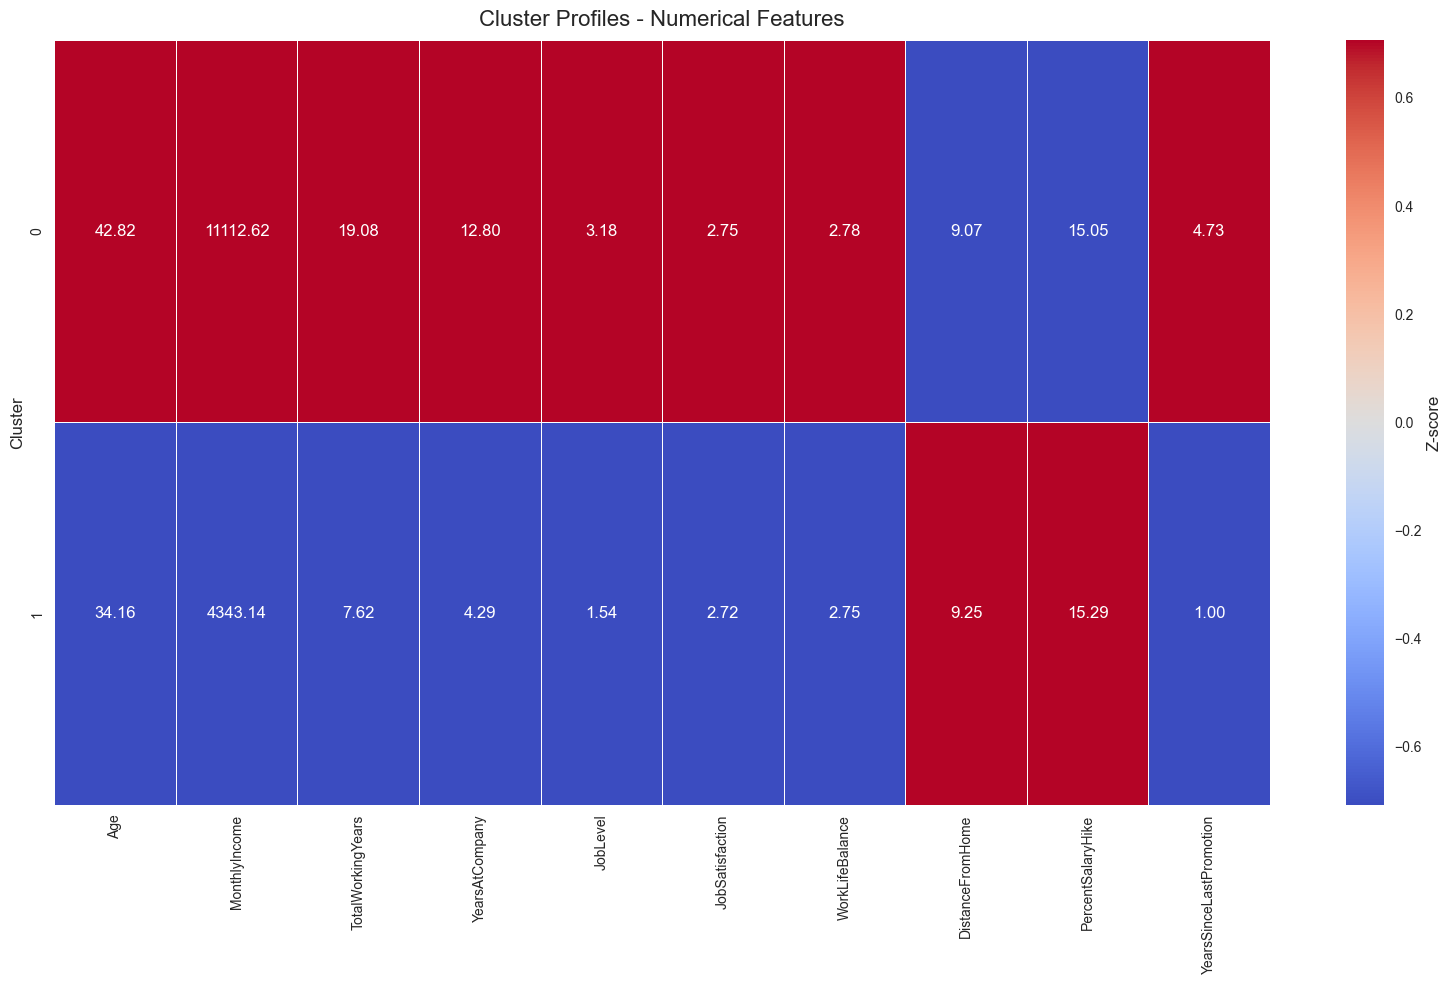

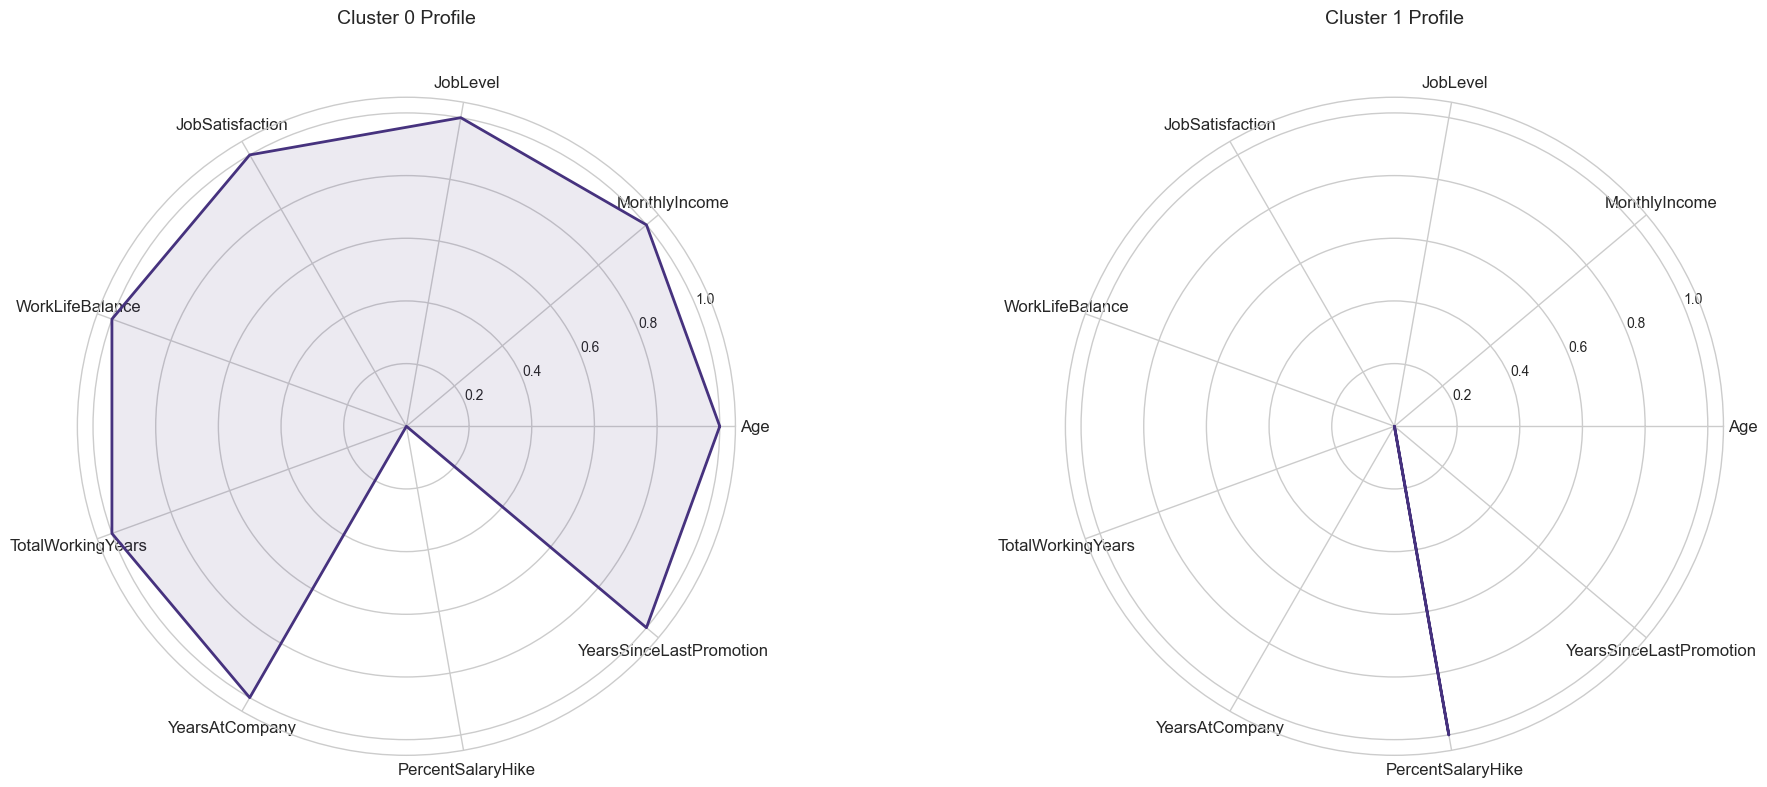

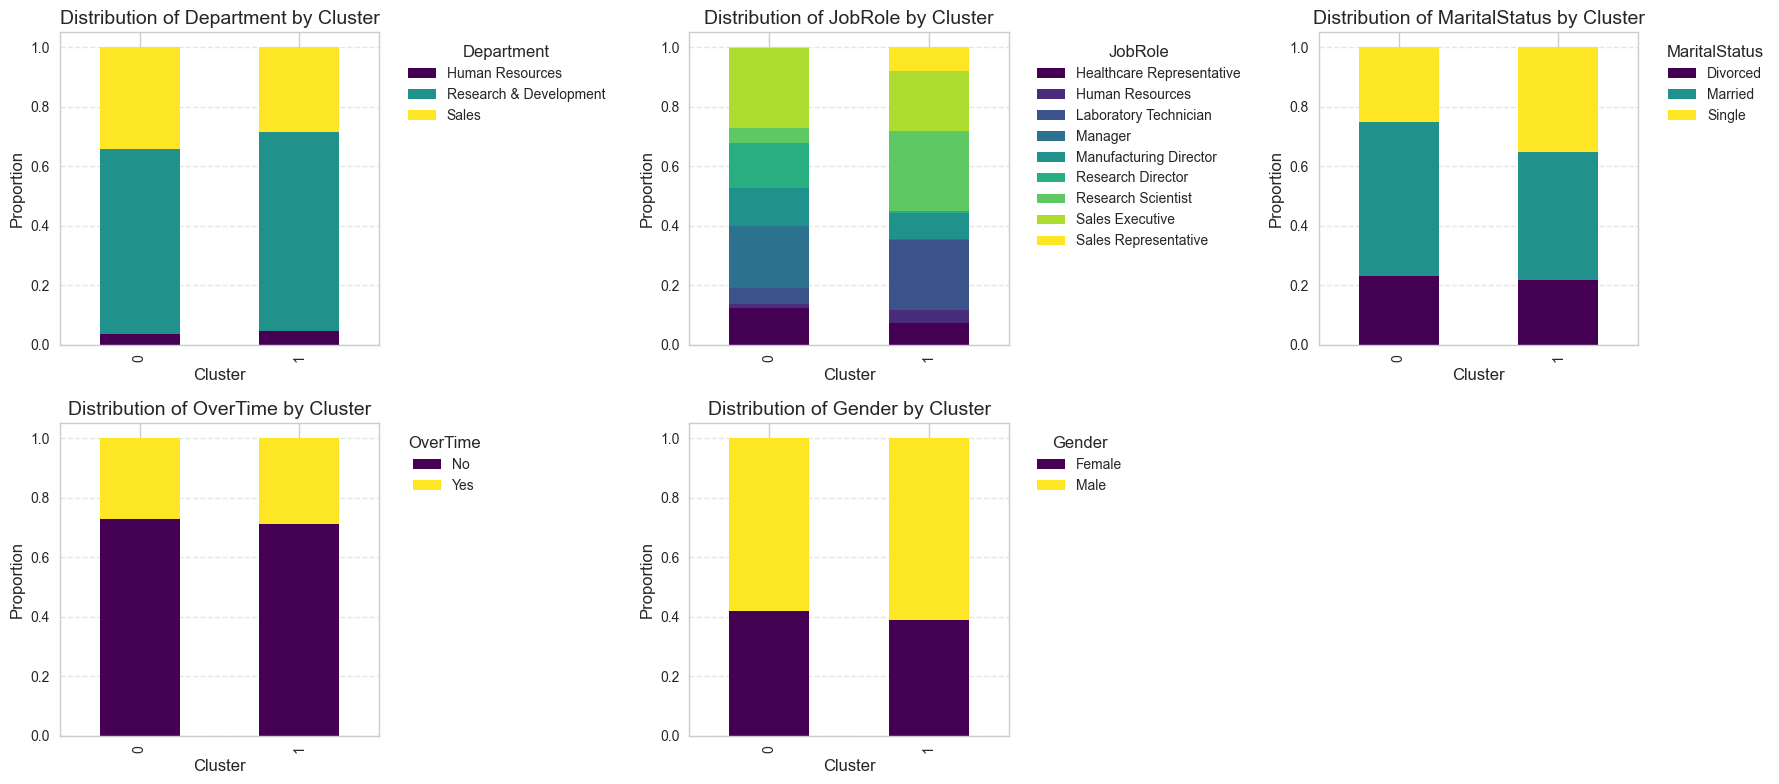

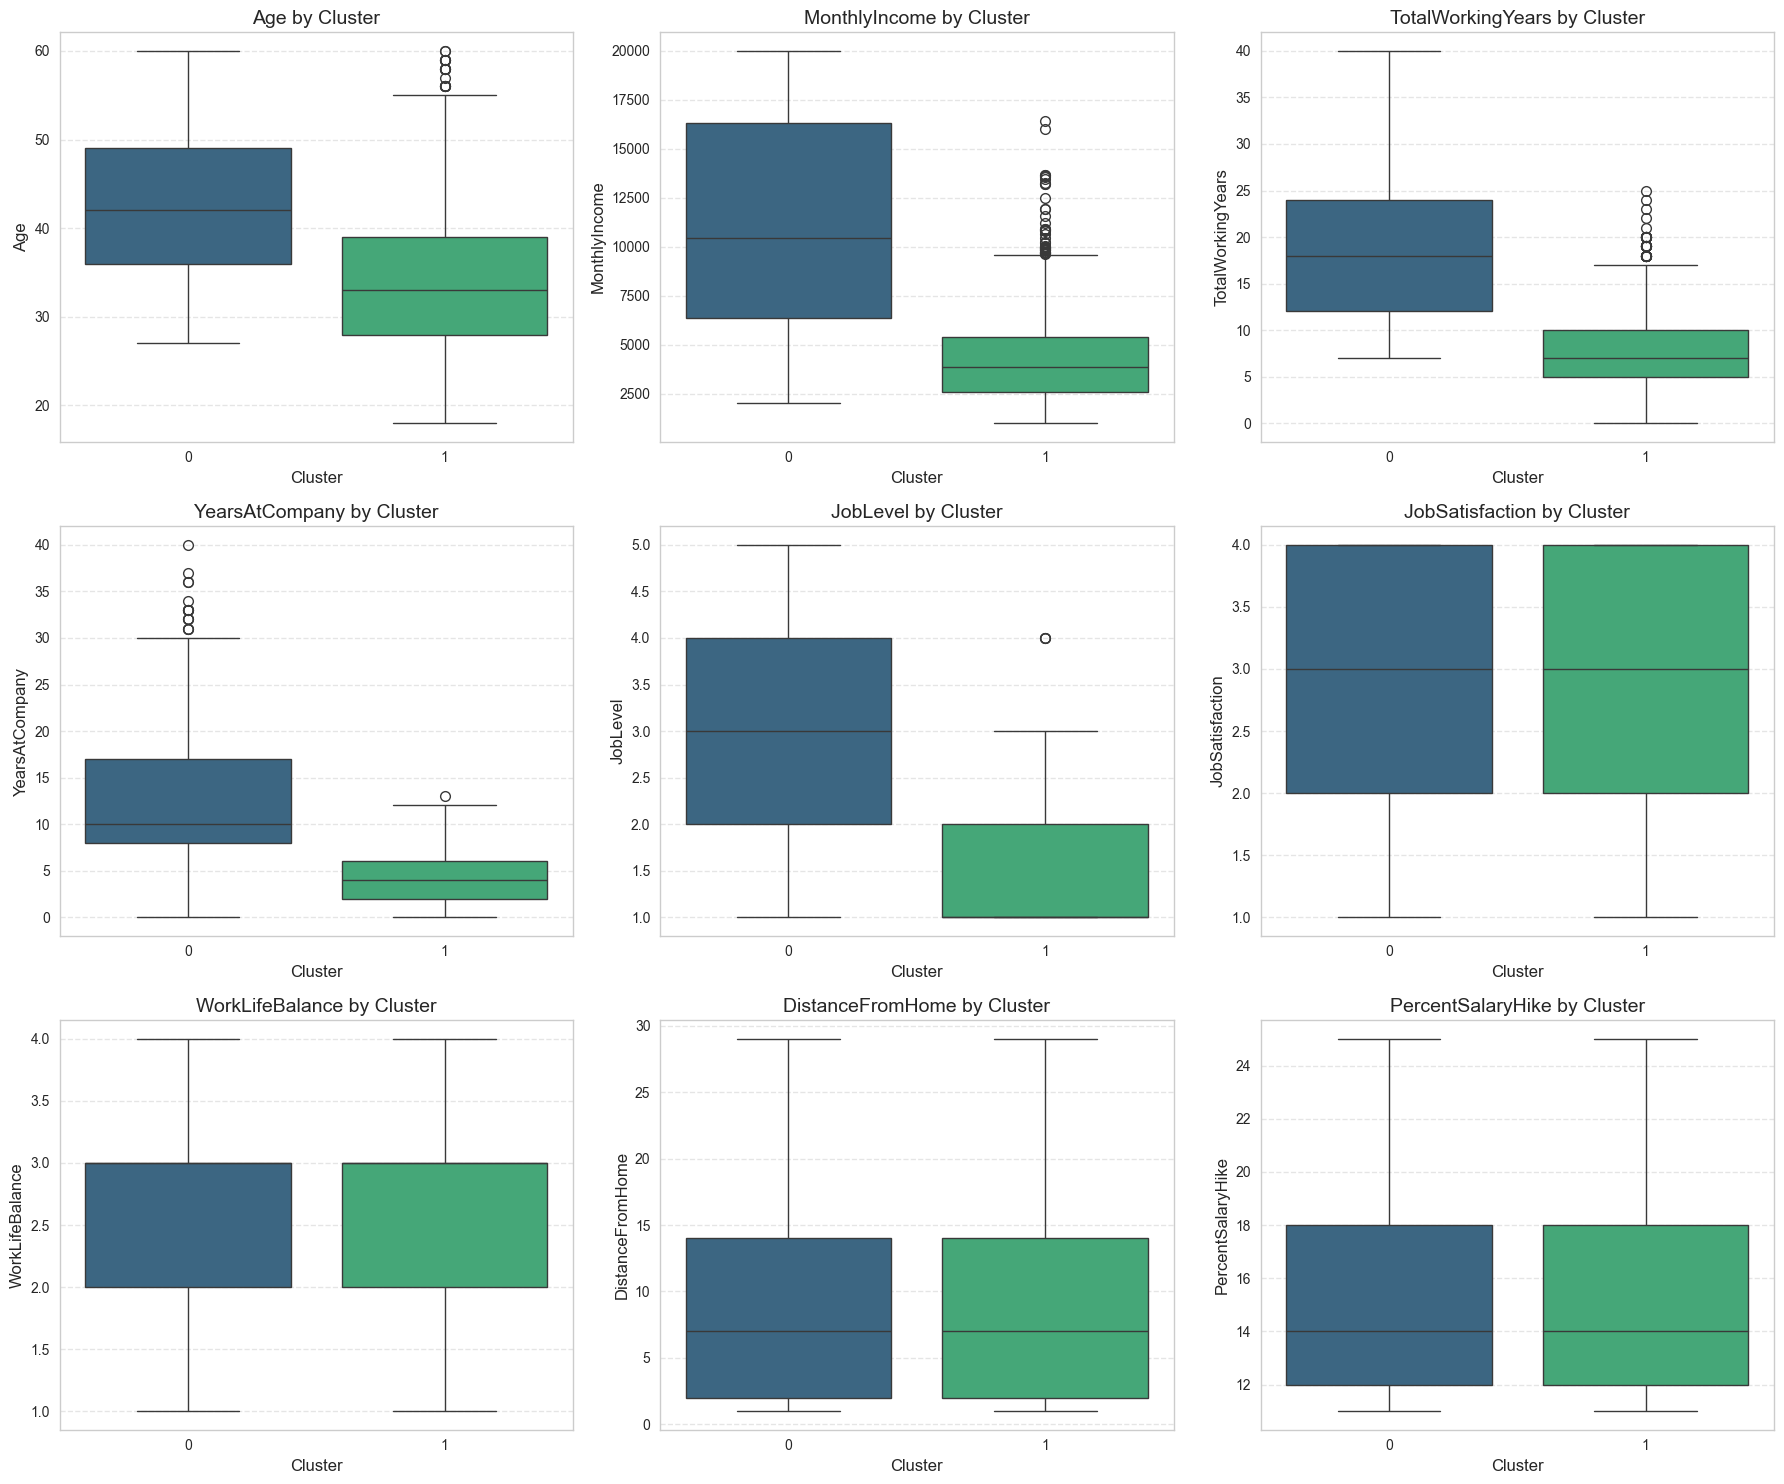

In [ ]:

import math

def analyze_clusters(df, 
                    key_numerical_features=None, 
                    key_categorical_features=None,
                    radar_features=None,
                    optimal_k=None):
    """
    Analyze and visualize cluster profiles using numerical and categorical features.
    
    """
    
    # Cluster sizes
    cluster_sizes = df['Cluster'].value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_sizes)
    
    # Visualize cluster sizes
    plt.figure(figsize=(12, 6))
    cluster_sizes.plot(kind='bar', color=sns.color_palette('viridis', n_colors=len(cluster_sizes)))
    plt.title('Number of Employees in Each Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Number of Employees', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    for i, v in enumerate(cluster_sizes):
        plt.text(i, v + 5, str(v), ha='center')
    plt.tight_layout()
    plt.show()
    
    # -------------------------
    # 1. Numerical Feature Averages by Cluster
    # -------------------------
    if key_numerical_features is None:
        key_numerical_features = [
            'Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 
            'JobLevel', 'JobSatisfaction', 'WorkLifeBalance', 'DistanceFromHome',
            'PercentSalaryHike', 'YearsSinceLastPromotion'
        ]
    
    cluster_profile_num = df.groupby('Cluster')[key_numerical_features].mean()
    print("\n=== Numerical Feature Averages by Cluster ===")
    print(cluster_profile_num.round(2))
    
    # -------------------------
    # 2. Heatmap of Numerical Features Across Clusters
    # -------------------------
    plt.figure(figsize=(16, 10))
    
    # Scale data (Z-score) for better heatmap visualization
    cluster_profile_scaled = (cluster_profile_num - cluster_profile_num.mean()) / cluster_profile_num.std()
    
    sns.heatmap(
        cluster_profile_scaled, 
        annot=cluster_profile_num.round(2), 
        cmap='coolwarm', 
        fmt='.2f', 
        linewidths=0.5, 
        cbar_kws={"label": "Z-score"}
    )
    plt.title('Cluster Profiles - Numerical Features', fontsize=16, pad=10)
    plt.tight_layout()
    plt.show()
    
    # -------------------------
    # 3. Radar (Spider) Charts for Each Cluster
    # -------------------------
    # Helper function to create a single radar chart
    def make_spider_chart(cluster_data, cluster_num, features):
        """
        Creates a single radar chart for the specified cluster.
        
        Parameters
        ----------
        cluster_data : pd.DataFrame
            DataFrame containing scaled (0-1) values for each cluster and feature.
        cluster_num : int
            The cluster index to plot.
        features : list of str
            The numerical features to include on the radar.
        """
        N = len(features)
        
        # Angles for each axis
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # close the loop
        
        # Retrieve cluster data and close the loop
        values = cluster_data.loc[cluster_num, features].values.tolist()
        values += values[:1]
        
        # Create subplots with polar projection
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        # Draw one axis per variable + add labels
        plt.xticks(angles[:-1], features, size=12)
        
        # Plot and fill
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster_num}')
        ax.fill(angles, values, alpha=0.1)
        
        # Title
        plt.title(f'Cluster {cluster_num} Profile', size=15, y=1.1)
        
        return fig, ax
    
    # If not provided, pick a default subset for radar charts
    if radar_features is None:
        radar_features = [
            'Age', 'MonthlyIncome', 'JobLevel', 'JobSatisfaction',
            'WorkLifeBalance', 'TotalWorkingYears', 'YearsAtCompany',
            'PercentSalaryHike', 'YearsSinceLastPromotion'
        ]
    
    # Prepare data for radar chart (Min-Max scaling each feature by cluster)
    radar_data = cluster_profile_num[radar_features].copy()
    for feature in radar_features:
        min_val = radar_data[feature].min()
        max_val = radar_data[feature].max()
        radar_data[feature] = (radar_data[feature] - min_val) / (max_val - min_val + 1e-9)  # small epsilon to avoid /0
    
    # Infer number of clusters if not provided
    if optimal_k is None:
        optimal_k = df['Cluster'].max() + 1 
    
    # Plot a radar chart for each cluster in subplots
    n_cols = 2
    n_rows = math.ceil(optimal_k / n_cols)
    plt.figure(figsize=(10 * n_cols, 8 * n_rows))
    
    for i in range(optimal_k):
        plt.subplot(n_rows, n_cols, i+1, polar=True)
        # Reuse the same spider chart function, but now we just return the axes
        angles = [n / float(len(radar_features)) * 2 * np.pi for n in range(len(radar_features))]
        angles += angles[:1]
        
        values = radar_data.loc[i, radar_features].values.tolist()
        values += values[:1]
        
        # Plot
        plt.xticks(angles[:-1], radar_features, size=12)
        plt.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        plt.fill(angles, values, alpha=0.1)
        plt.title(f'Cluster {i} Profile', size=14, y=1.1)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------
    # 4. Categorical Feature Distribution by Cluster
    # -------------------------
    if key_categorical_features is None:
        key_categorical_features = ['Department', 'JobRole', 'MaritalStatus', 'OverTime', 'Gender']
    
    # Create subplots for all categorical features in one figure
    n_cols = 3
    n_rows = math.ceil(len(key_categorical_features) / n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, feature in enumerate(key_categorical_features):
        ax = axes[i]
        # Normalize by cluster to get proportions
        cat_dist = pd.crosstab(df['Cluster'], df[feature], normalize='index')
        cat_dist.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
        
        ax.set_title(f'Distribution of {feature} by Cluster', fontsize=14)
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel('Proportion', fontsize=12)
        ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Hide extra axes if any
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------
    # 5. Box Plots for Key Numerical Features Across Clusters
    # -------------------------
    # Adjust how many you want to show if you have many features
    selected_box_features = key_numerical_features[:9]
    n_cols = 3
    n_rows = math.ceil(len(selected_box_features) / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, feature in enumerate(selected_box_features):
        ax = axes[i]
        sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis', ax=ax)
        ax.set_title(f'{feature} by Cluster', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Hide extra axes if any
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


# Example: Calling the analyze_clusters function
analyze_clusters(
    df=df,
    key_numerical_features=[
        'Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 
        'JobLevel', 'JobSatisfaction', 'WorkLifeBalance', 'DistanceFromHome',
        'PercentSalaryHike', 'YearsSinceLastPromotion'
    ],
    key_categorical_features=[
        'Department', 'JobRole', 'MaritalStatus', 'OverTime', 'Gender'
    ],
    radar_features=[
        'Age', 'MonthlyIncome', 'JobLevel', 'JobSatisfaction',
        'WorkLifeBalance', 'TotalWorkingYears', 'YearsAtCompany',
        'PercentSalaryHike', 'YearsSinceLastPromotion'
    ],
    optimal_k=optimal_k
)


### Cluster Comparison Summary

> Clusters show strong contrast in profile and risk.

- **Cluster 0** (Low Attrition – 8.5%):
  - Older, higher-paid, more tenured
  - More Research Directors and Managers
  - Less concentrated in Sales
  - Comparable overtime and satisfaction

- **Cluster 1** (High Attrition – 19.7%):
  - Younger, lower-paid, less experienced
  - Heavily represented in Sales and Laboratory Tech roles
  - Slightly higher overtime and shorter tenure

### Key Drivers of Attrition
>> Age, income, job role, and years at company are stronger differentiators than satisfaction or overtime.

### Implication

Retention strategy should prioritize support and growth for early-career staff in operational roles, especially in Sales.
____

>## 6. Business Insights and Recommendations

In [264]:
import pandas as pd

def create_cluster_summary(df):
    """
    Creates a summary DataFrame of key cluster characteristics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the cluster information and relevant features.
        It must include the following columns:
            - 'Cluster'
            - 'Attrition' (with values 'Yes' or 'No')
            - 'Age'
            - 'MonthlyIncome'
            - 'YearsAtCompany'
            - 'JobSatisfaction'
            - 'WorkLifeBalance'
            - 'OverTime' (with values 'Yes' or 'No')
            - 'Department'
            - 'JobRole'
    
    Returns:
    --------
    cluster_summary : pandas.DataFrame
        A DataFrame summarizing key metrics for each cluster.
    """
    cluster_summary = pd.DataFrame()
    
    # Basic demographics and performance metrics
    cluster_summary['Size'] = df['Cluster'].value_counts().sort_index()
    cluster_summary['Attrition_Rate'] = (
        df.groupby('Cluster')['Attrition']
          .apply(lambda x: (x == 'Yes').mean() * 100)
          .sort_index()
          .round(1)
    )
    cluster_summary['Avg_Age'] = df.groupby('Cluster')['Age'].mean().round(1)
    cluster_summary['Avg_Monthly_Income'] = df.groupby('Cluster')['MonthlyIncome'].mean().round(0)
    cluster_summary['Avg_Years_At_Company'] = df.groupby('Cluster')['YearsAtCompany'].mean().round(1)
    cluster_summary['Avg_Job_Satisfaction'] = df.groupby('Cluster')['JobSatisfaction'].mean().round(1)
    cluster_summary['Avg_Work_Life_Balance'] = df.groupby('Cluster')['WorkLifeBalance'].mean().round(1)
    cluster_summary['Overtime_Pct'] = (
        df.groupby('Cluster')['OverTime']
          .apply(lambda x: (x == 'Yes').mean() * 100)
          .sort_index()
          .round(1)
    )
    
    # Most common department and job role per cluster
    cluster_summary['Top_Department'] = df.groupby('Cluster')['Department'].agg(
        lambda x: x.value_counts().index[0]
    )
    cluster_summary['Top_JobRole'] = df.groupby('Cluster')['JobRole'].agg(
        lambda x: x.value_counts().index[0]
    )
    
    return cluster_summary


# Create the summary DataFrame from your DataFrame `df`
cluster_summary = create_cluster_summary(df)
print("Cluster Summary:")
display(cluster_summary)

# Optionally, assign descriptive names to clusters
cluster_names = {
    0: 'High-Tenure Satisfied Employees',
    1: 'Mid-Tenure Average Employees',
    2: 'Low-Tenure High Attrition',
    # Extend this dictionary as needed for additional clusters
}

# Map the cluster numbers to descriptive names in the summary's index
cluster_summary.index = cluster_summary.index.map(
    lambda x: f"Cluster {x} ({cluster_names.get(x, 'Undefined')})"
)

print("Cluster Summary with Descriptive Names:")
display(cluster_summary)


Cluster Summary:


Size  Attrition_Rate  Avg_Age  Avg_Monthly_Income  Avg_Years_At_Company  \
0   469             0.0     42.8             11113.0                  12.8   
1  1001             0.0     34.2              4343.0                   4.3   

   Avg_Job_Satisfaction  Avg_Work_Life_Balance  Overtime_Pct  \
0                   2.8                    2.8          27.3   
1                   2.7                    2.8          28.8   

           Top_Department         Top_JobRole  
0  Research & Development     Sales Executive  
1  Research & Development  Research Scientist

Cluster Summary with Descriptive Names:


Size  Attrition_Rate  Avg_Age  \
Cluster 0 (High-Tenure Satisfied Employees)   469             0.0     42.8   
Cluster 1 (Mid-Tenure Average Employees)     1001             0.0     34.2   

                                             Avg_Monthly_Income  \
Cluster 0 (High-Tenure Satisfied Employees)             11113.0   
Cluster 1 (Mid-Tenure Average Employees)                 4343.0   

                                             Avg_Years_At_Company  \
Cluster 0 (High-Tenure Satisfied Employees)                  12.8   
Cluster 1 (Mid-Tenure Average Employees)                      4.3   

                                             Avg_Job_Satisfaction  \
Cluster 0 (High-Tenure Satisfied Employees)                   2.8   
Cluster 1 (Mid-Tenure Average Employees)                      2.7   

                                             Avg_Work_Life_Balance  \
Cluster 0 (High-Tenure Satisfied Employees)                    2.8   
Cluster 1 (Mid-Tenure Average Employees)                       2.8   

                                             Overtime_Pct  \
Cluster 0 (High-Tenure Satisfied Employees)          27.3   
Cluster 1 (Mid-Tenure Average Employees)             28.8   

                                                     Top_Department  \
Cluster 0 (High-Tenure Satisfied Employees)  Research & Development   
Cluster 1 (Mid-Tenure Average Employees)     Research & Development   

                                                    Top_JobRole  
Cluster 0 (High-Tenure Satisfied Employees)     Sales Executive  
Cluster 1 (Mid-Tenure Average Employees)     Research Scientist

## Employee Attrition Analysis – Business Recommendations

> **Objective:**  
> Understand and reduce attrition using employee data clustering and profiling.

### Key Insights

> **1. Attrition Drivers Identified**  
>> Top predictors: Monthly Income, Age, Tenure, Job Satisfaction, and OverTime.  
>> At-risk profile: Younger employees with mid-level tenure and lower compensation.

> **2. Segmentation Results (K-Means Clustering)**  
>> **Cluster 0 – High-Tenure Satisfied Employees**  
>>> Older, higher income, longer tenure, satisfied, attrition rate: 8.5%  
>>> Dominant role: Sales Executive  

>> **Cluster 1 – Mid-Tenure Average Employees**  
>>> Younger, lower income, moderate tenure, higher attrition: 19.7%  
>>> Dominant role: Research Scientist  

> **3. Validation of Segmentation**  
>> PCA confirms visual separation.  
>> Multiple clustering metrics (Elbow, Silhouette, Calinski-Harabasz, Davies-Bouldin) support optimal k = 2.  

### Business Actions

> **For Cluster 1 (High-Risk Group):**  
>> - Improve compensation fairness and promotion timelines  
>> - Prioritize development plans for employees in early/mid-career stages  
>> - Introduce flexible or hybrid work policies to improve retention  

> **For Cluster 0 (Stable Segment):**  
>> - Preserve current engagement strategies  
>> - Use this group to mentor others or lead internal initiatives  

### Final Recommendation

> This notebook provides a clear employee segmentation strategy.  
>> It supports targeted retention and workforce optimization through:  
>>> - Validated clustering  
>>> - Insightful profiling  
>>> - Clear HR actions  

> **Use this analysis to inform data-driven HR policy and early attrition interventions.**
